# Metabolomic Analysis of Extraction Human Urine (C18 Chromatography, Positive Ionization Mode)
This notebook uses several packages from CRAN, as well as [Bioconductor](https://bioconductor.org). For a full list of attached packages see the session info in the Appendix at the end of this notebook. Several options have been adjusted to improve appearance of plots.

## Quality Control of Raw Data

In [1]:
## Load necessary packages
suppressMessages({
    
    library("xcms")
    library("CAMERA")
    library("RColorBrewer")
    library("SummarizedExperiment")
    library("tidyverse")
    library("gplots")
    library("Rtsne")
    library("caret")
    library("MASS")
    library("ggrepel")
    library("writexl")
    library("matrixStats")
    library("devtools")
    library("ggpubr")
    
    
})

## Set session-specific options
options(repr.plot.width = 12, repr.plot.height = 6, repr.plot.res = 120, scipen = -1)

## Define %notin% operator
`%notin%` <- Negate(`%in%`)

Warning message in fun(libname, pkgname):
“mzR has been built against a different Rcpp version (1.0.9)
than is installed on your system (1.0.10). This might lead to errors
when loading mzR. If you encounter such issues, please send a report,
including the output of sessionInfo() to the Bioc support forum at 
https://support.bioconductor.org/. For details see also
https://github.com/sneumann/mzR/wiki/mzR-Rcpp-compiler-linker-issue.”


In [2]:
## List mzXML files
mzXMLs <- list.files(path = "~/Urin_Extraktion_Human/C18_pos", recursive = TRUE, 
                    full.names = TRUE, pattern = ".mzXML")

## Aggregate meta data
sample.name <- sub(basename(mzXMLs), pattern = ".mzXML", 
                   replacement = "", fixed = TRUE)
sample.group <- c(rep("Preparation_1_1", 5), rep("Preparation_1_2", 5), rep("Preparation_1_3", 5), 
                  rep("Preparation_2_1", 5), rep("Preparation_2_2", 5), rep("Preparation_2_3", 5), 
                  rep("Preparation_3_1", 5), rep("Preparation_3_2", 5), rep("Preparation_3_3", 5),
                  rep("Preparation_4_1", 5), rep("Preparation_4_2", 5),rep("Preparation_4_3", 5), rep("QC", 11))
sample.weight <- c(4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,
                   1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,NA,NA, NA, NA, NA, NA, NA, NA, NA, NA, NA)
sample.weight[is.na(sample.weight) == TRUE] <- mean(sample.weight, na.rm = TRUE) %>%
                                               round(0)
analysis.order <- c(54, 11, 62, 70, 23, 63, 17, 36, 51, 34, 55, 6, 31, 58, 14, 43, 25, 64, 44, 10, 42, 50, 61, 53, 
                  30, 33, 52, 40, 7, 9, 67, 69, 65, 46, 19, 28, 32, 45, 66, 22, 18, 39, 68, 24, 35, 37, 47, 8, 
                  20, 15, 56, 57, 48, 29, 59, 41, 21, 12, 26, 13, 1, 2, 3, 4, 5, 16, 27, 38, 49, 60, 71)
analysis.batch <- NA
meta <- data.frame(sample_name = sample.name, 
                   sample_group = sample.group,
                   sample_weight = sample.weight,
                   analysis_order = analysis.order,
                   analysis_batch = analysis.batch, 
                   stringsAsFactors = FALSE)

In [3]:
## Read raw data from disk
raw <- readMSData(files = mzXMLs[order(analysis.order)], 
                  pdata = new("AnnotatedDataFrame", 
                              meta[order(analysis.order),]), 
                  mode = "onDisk")

## Inspection of Internal Standards
This experiment used the following stable isotope labeled standards to normalise variability introduced by injection of the samples into the mass spectrometer:
- creatinine-d3, \[M+H\]: *m/z* 117.0856
- tryptophan-d5, \[M+H\]: *m/z* 210.1285, \[M-H\]: *m/z* 208.1140
- glucose-d7, \[M-H\]: *m/z* 186.1000
- palmitic acid-31, \[M-H\]: *m/z* 286.4275

Quality control at this stage includes ensuring that the internal standards have been detected properly and the within group variability is acceptable.

In [4]:
## Define colours for experimental groups
group.colours <- paste0(c(brewer.pal(8, name = "Set2"),brewer.pal(5, name = "Set1")) [1:13])
names(group.colours) <- c("Preparation_1_1", "Preparation_1_2", "Preparation_1_3", "Preparation_2_1", "Preparation_2_2",
                          "Preparation_2_3", "Preparation_3_1", "Preparation_3_2", "Preparation_3_3", "Preparation_4_1", 
                          "Preparation_4_2", "Preparation_4_3", "QC")

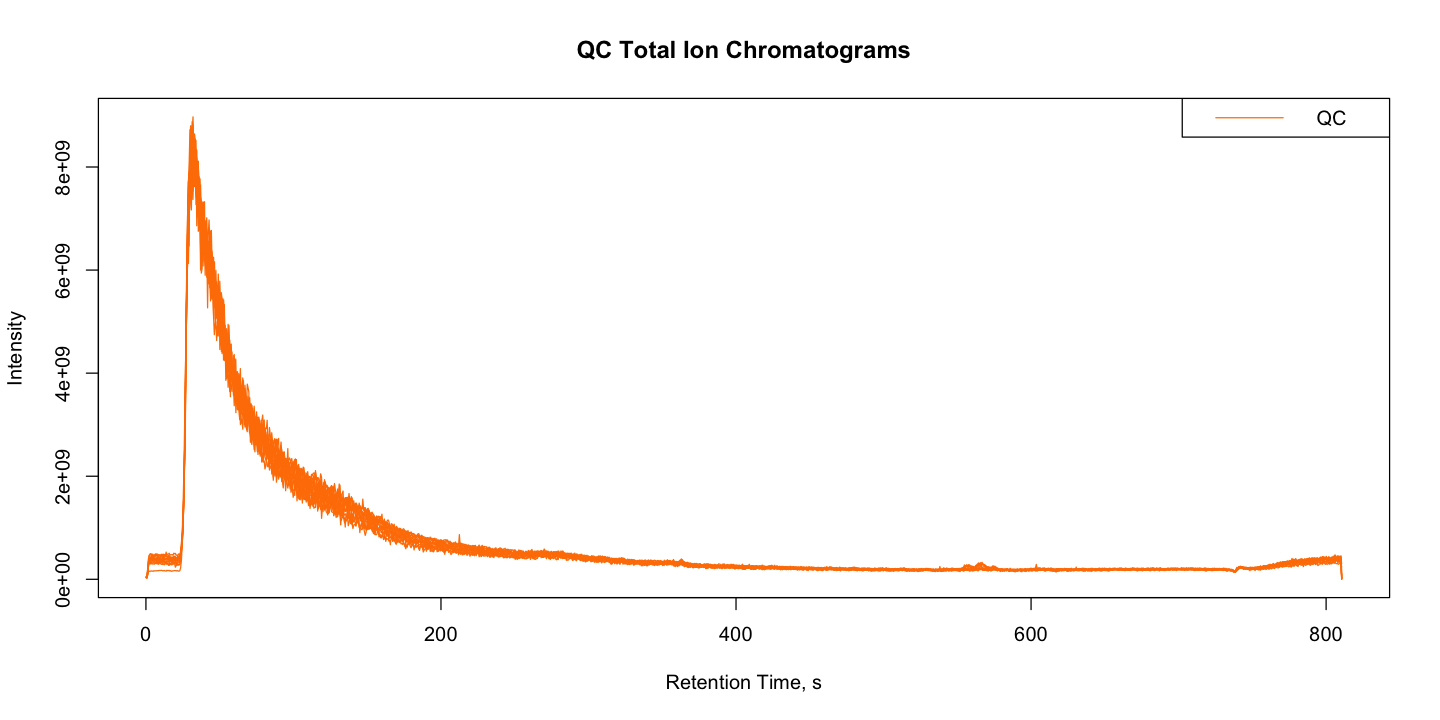

In [5]:
## Get TIC chromatograms
chroms <- chromatogram(raw)

## Plot every QC chromatogram of the data set
plot(chroms[,chroms$sample_group == "QC"], col = group.colours[chroms$sample_group],
     main = "QC Total Ion Chromatograms", ylab = "Intensity", 
     xlab = "Retention Time, s")
legend("topright", legend = "QC", 
       col = group.colours[names(group.colours) == "QC"], lty = 1)

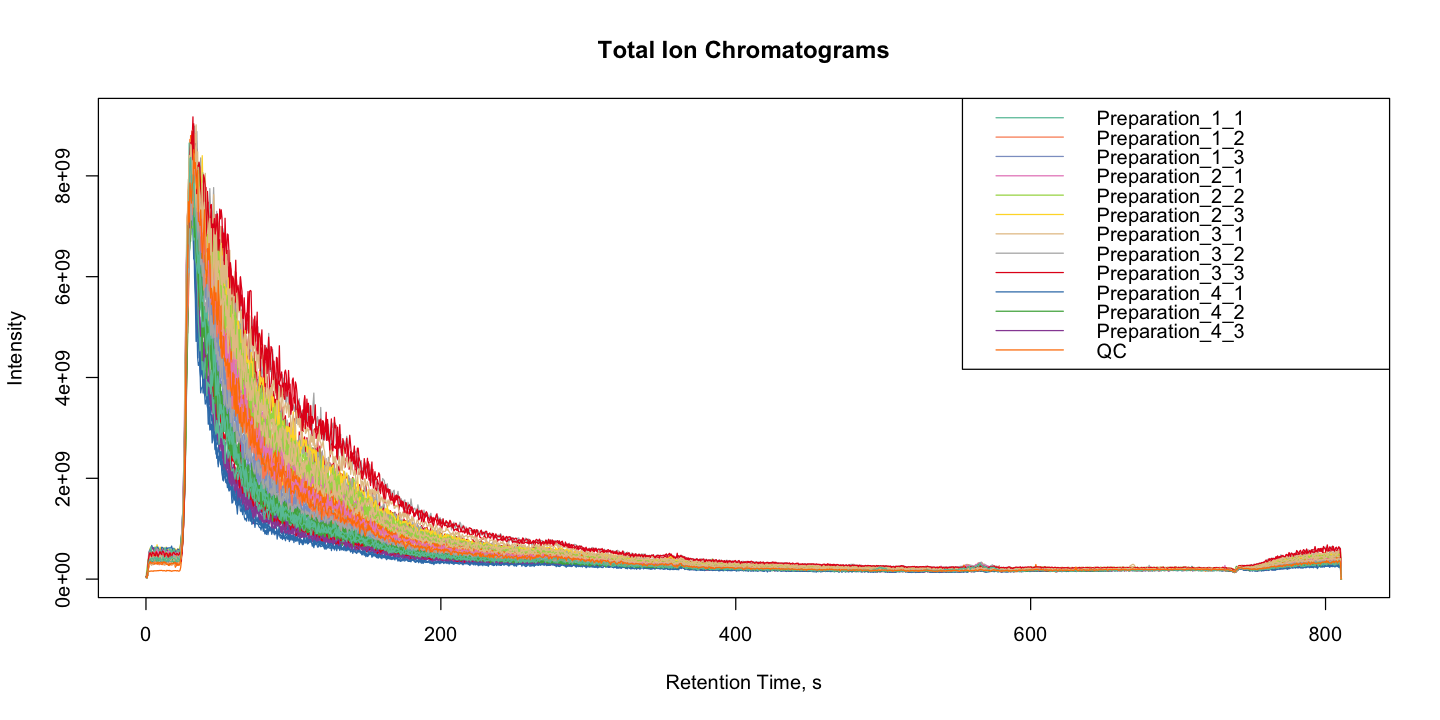

In [6]:
## Plot every chromatogram of the data set
plot(chroms, col = group.colours[chroms$sample_group],
     main = "Total Ion Chromatograms", ylab = "Intensity", 
     xlab = "Retention Time, s")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

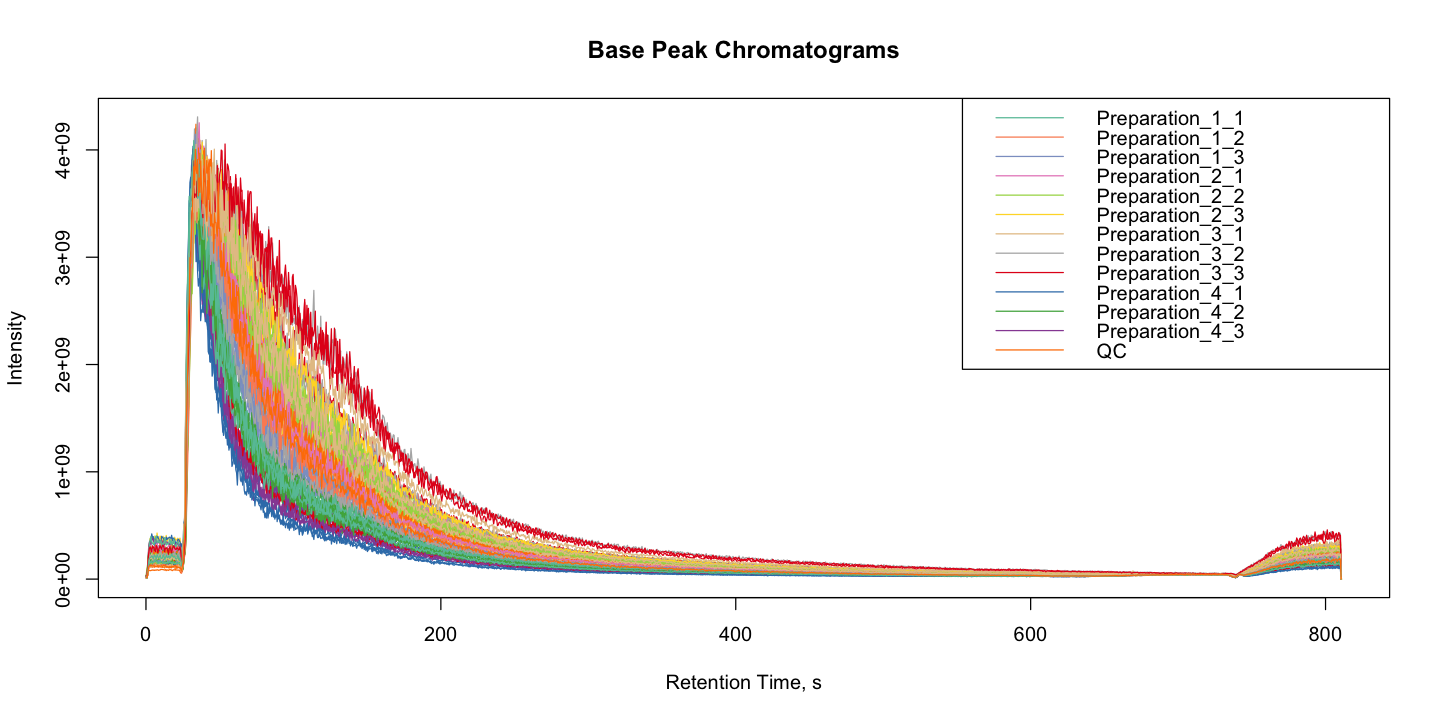

In [7]:
## Get base peak chromatograms
bps <- chromatogram(raw, aggregationFun = "max")

## Plot every base peak chromatogram of the data set
plot(bps, col = group.colours[raw$sample_group], 
     main = "Base Peak Chromatograms", ylab = "Intensity", 
     xlab = "Retention Time, s")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

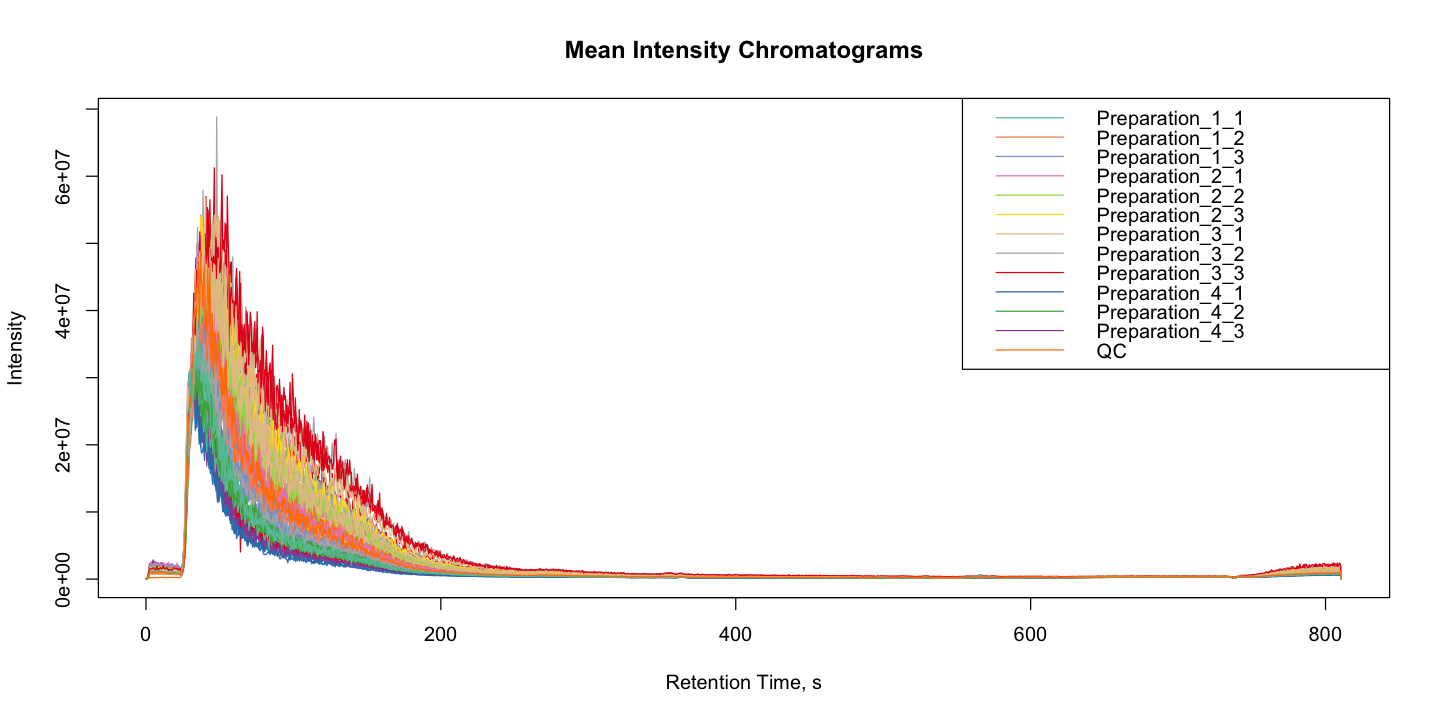

In [8]:
## Get mean intensity chromatograms
means <- chromatogram(raw, aggregationFun = "mean")

## Plot every mean intensity chromatogram of the data set
plot(means, col = group.colours[raw$sample_group], 
     main = "Mean Intensity Chromatograms", ylab = "Intensity", 
     xlab = "Retention Time, s")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

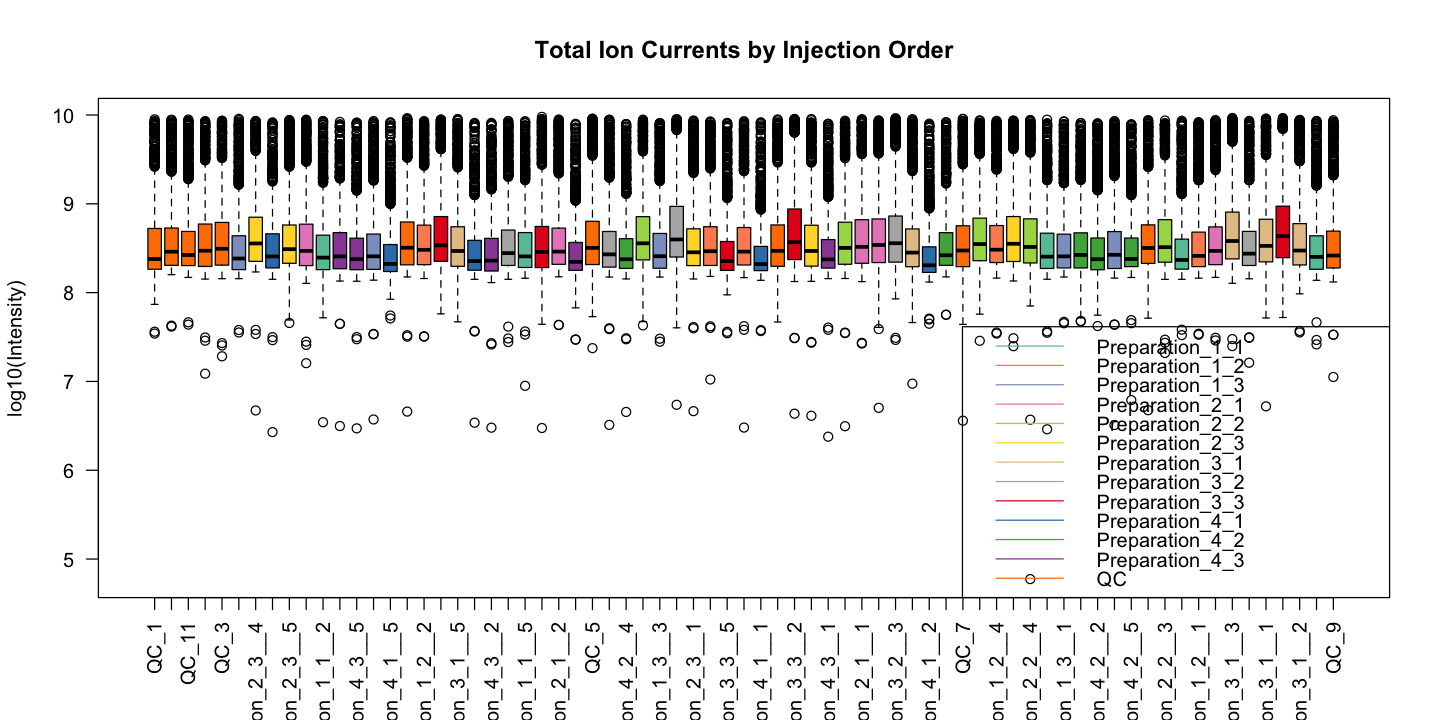

In [9]:
# Inspect boxplots of TICs by injection order
tics.summary <- split(tic(raw), f = fromFile(raw))

boxplot(sapply(tics.summary, log10), names = raw$sample_name, 
        col = group.colours[raw$sample_group], ylab = "log10(Intensity)", 
        main = "Total Ion Currents by Injection Order", las = 2)
legend("bottomright", legend = names(group.colours), 
       col = group.colours, lty = 1)

In [10]:
# Inspect boxplots of TICs by sample group
boxplot(sapply(tics.summary, log10)[,order(raw$sample_group)], 
        names = raw$sample_name[order(raw$sample_group)], 
        col = (group.colours[raw$sample_group])[order(raw$sample_group)], 
        ylab = "log10(Intensity)", 
        main = "Total Ion Currents by Sample Group", las = 2)
legend("bottomright", legend = names(group.colours), col = group.colours, lty = 1)

ERROR: Error in h(simpleError(msg, call)): Fehler bei der Auswertung des Argumentes 'x' bei der Methodenauswahl für Funktion 'boxplot': falsche Anzahl von Dimensionen


## Preprocessing of Raw Sample Files

### Peak Picking
Parameter used in this section were obtained using the one-by-one optimization performed by [centWaveOpt](https://github.com/saskema/centWaveOpt). This approach was published at [DOI: 10.1002/dta.2552](https://doi.org/10.1002/dta.2552) by Manier et al.

In [11]:
cwp <- CentWaveParam(peakwidth = c(7.8, 15), ppm = 2.5, snthresh = 75, 
                     mzdiff = 0.034,  prefilter = c(5, 100))

suppressMessages(
    
    set <- findChromPeaks(raw, param = cwp)
    
    )

In [12]:
## Define sample colours
sample.colours <- paste0(c(brewer.pal(8, name = "Set2"),brewer.pal(5, name = "Set1")) [1:13], "60")
names(sample.colours) <- c("Preparation_1_1", "Preparation_1_2", "Preparation_1_3", "Preparation_2_1", "Preparation_2_2",
                          "Preparation_2_3", "Preparation_3_1", "Preparation_3_2", "Preparation_3_3", "Preparation_4_1", 
                          "Preparation_4_2", "Preparation_4_3", "QC")
sample.colours <- sample.colours[raw$sample_group]

### Retention Time Correction (RT)

In [13]:
suppressMessages({
    
    set <- adjustRtime(set, param = ObiwarpParam(binSize = 0.6))
    set <- dropAdjustedRtime(set)

    pdp <- PeakDensityParam(sampleGroups = set$sample_group, bw = 1.0)
    set <- groupChromPeaks(set, param = pdp)

    ## Define subset alignment options and perform the alignment
    pgp <- PeakGroupsParam(minFraction = 0.85, 
                           subset = which(set$sample_group == "QC"),
                           subsetAdjust = "average", span = 0.4)
    set <- adjustRtime(set, param = pgp)
    
})

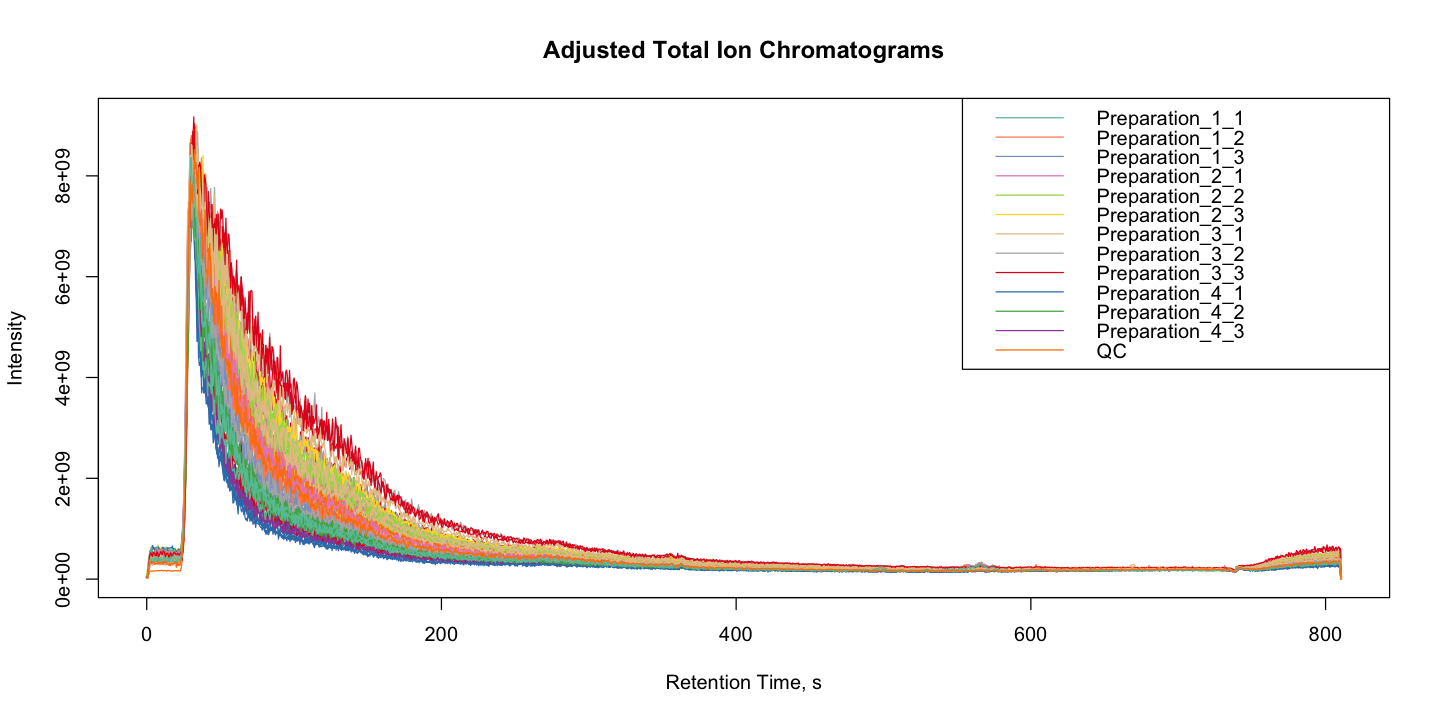

In [14]:
## Get the retention time-adjusted total ion chromatograms.
tics.corr <- chromatogram(set, aggregationFun = "sum")

plot(tics.corr, col = group.colours[tics.corr$sample_group], 
     peakType = "none", main = "Adjusted Total Ion Chromatograms", 
     xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), col = group.colours, lty = 1)

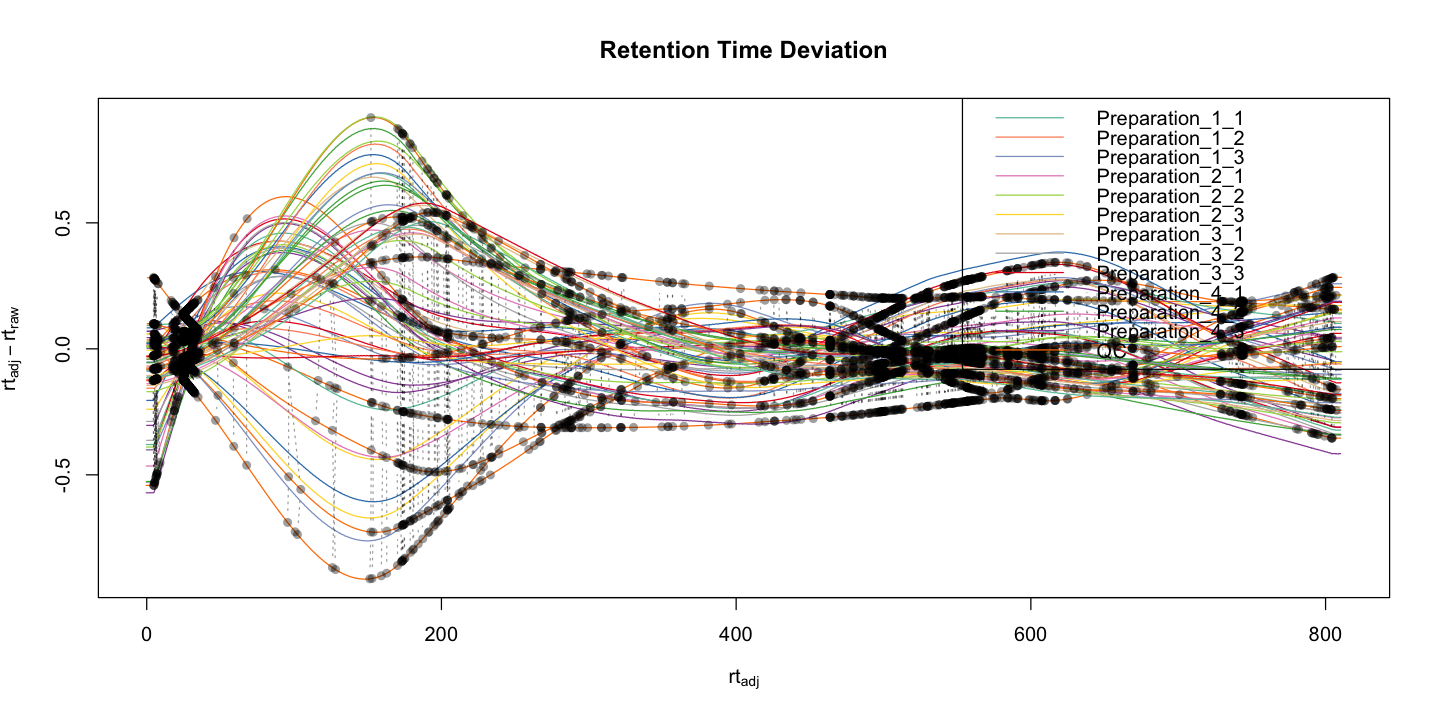

In [15]:
## Plot difference of adjusted to raw retention time.
plotAdjustedRtime(set, col = group.colours[set$sample_group], 
                  main = "Retention Time Deviation")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

### Peak Grouping

In [16]:
suppressMessages(
    
    set <- groupChromPeaks(set, param = pdp)
    
)

### Peak Filling

In [17]:
suppressMessages(    
     
    set <- fillChromPeaks(set, param = ChromPeakAreaParam())
    
)

## Post Processing

### Export Results to SummarizedExperiment-Object

In [18]:
## Summarise experiment
results <- quantify(set, value = "into")

In [19]:
## Summarise experiment
results <- quantify(set)

In [20]:
## Add classic feature names
rowData(results)$label <- paste0("M",round(rowData(results)$mzmed,0),
                           "T", round(rowData(results)$rtmed,0))

### Annotation of Adducts and Isotopes

In [21]:
## Perform annotation using CAMERA
suppressMessages({
    
    camera <- set %>%
              as("xcmsSet") %>%
              CAMERA::annotate(polarity  = "positive") %>%
              getPeaklist() %>%
              dplyr::select(isotopes, adduct, pcgroup)
    
})

## Save annotation results in SummarizedExperiment class
rowData(results)$isotopes <- camera$isotopes
rowData(results)$adduct <- camera$adduct
rowData(results)$pcgroup <- camera$pcgroup

Start grouping after retention time.
Created 171 pseudospectra.
Generating peak matrix!
Run isotope peak annotation
 % finished: 10  30  40  50  60  70  80  90  100  
Found isotopes: 155 
Start grouping after correlation.
Generating EIC's .. 

Calculating peak correlations in 171 Groups... 
 % finished: 10  30  40  50  60  70  80  90  100  

Calculating graph cross linking in 171 Groups... 
 % finished: 10  30  40  50  60  70  80  90  100  
New number of ps-groups:  564 
xsAnnotate has now 564 groups, instead of 171 
Generating peak matrix for peak annotation!

Calculating possible adducts in 564 Groups... 
 % finished: 10  20  30  40  50  60  70  80  90  100  


### Scaling
Before log10 transformation, every NA in the data matrix is replaced by the surrogate LOD according to Wehrens et al. at [DOI: 10.1007/s11306-016-1015-8](https://doi.org/10.1007/s11306-016-1015-8). The surrogate LOD is the lowest area that was measured during the analysis.

In [22]:
# Replacing NAs with surrogate LOD
lod <- assay(results, "raw")[is.na(assay(results, "raw")) == FALSE] %>%
       min()
assay(results, "raw")[is.na(assay(results, "raw"))] <- lod

In [23]:
# Create separate (scaled) assay results within same object
assay(results, "scaled") <- assay(results, "raw") %>%
                            log10()

## Normalisation to Extraction solvent

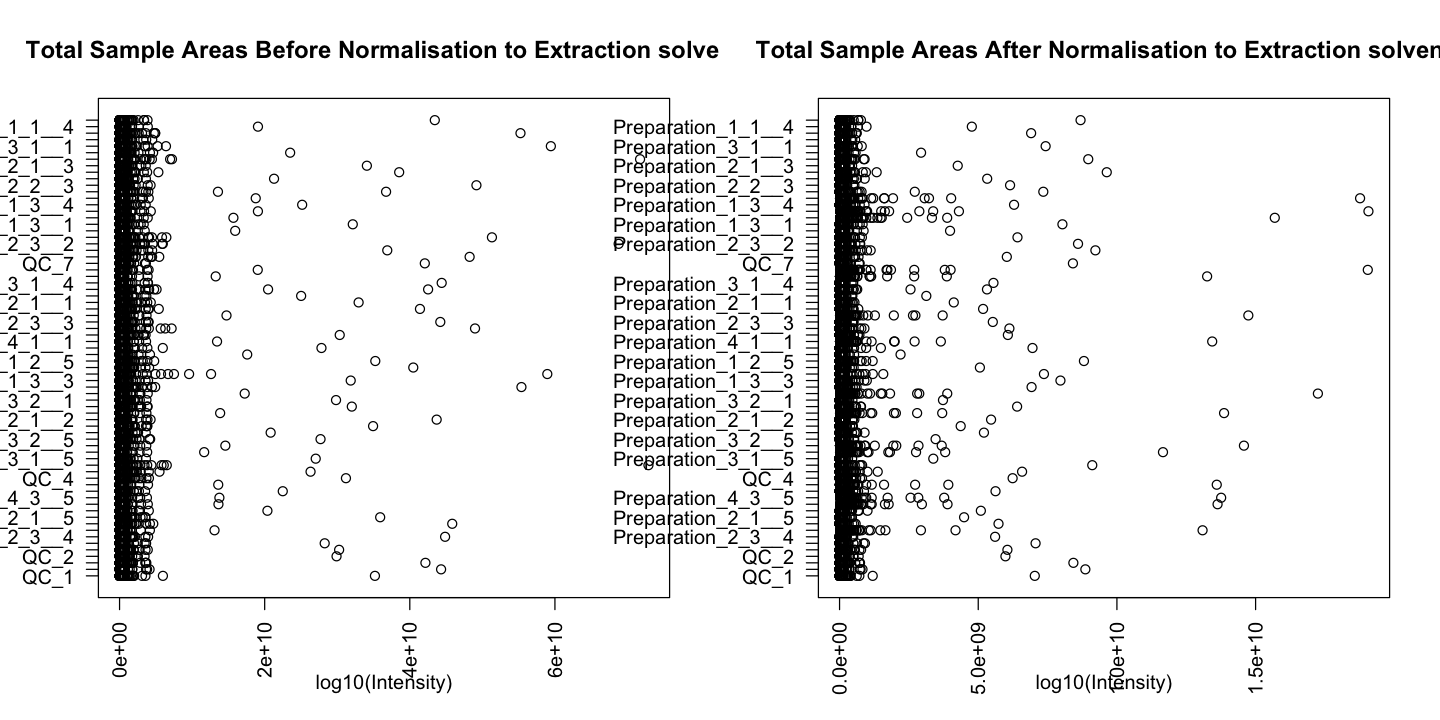

In [24]:
## Normalise data to extraction solvent
norm.weight <- function(x, weight){x / weight}

assay(results, "norm.weight") <- apply(assay(results, "raw"), 1, 
                                       norm.weight, weight = colData(results)$sample_weight) %>%
                                 t()

## Compare normalised and unnormalised data
par(mfrow = c(1,2))

results %>%
assay("raw") %>%
boxplot(names = results$sample_name, horizontal = TRUE,
        col = group.colours[results$sample_group], xlab = "log10(Intensity)", 
        main = "Total Sample Areas Before Normalisation to Extraction solvent", las = 2)

results %>%
assay("norm.weight") %>%
boxplot(names = results$sample_name, horizontal = TRUE,
        col = group.colours[results$sample_group], xlab = "log10(Intensity)", 
        main = "Total Sample Areas After Normalisation to Extraction solvent", las = 2)

# IS Area for IS in Extraction Solvents
- Carnitine-d9: [M+H] m/z 171.1690, rt 31 sec 
- Glutamic acid d3:[M+H] m/z 151.0793, rt 29 sec 
- Kynurenic acid d5: [M+H] m/z 195.0813, rt 177 sec 
- Lysin d3: [M+H] m/z 150.1316, rt 26 sec 
- Tryptophan d5: [M+H] m/z 210.1285, rt 172 sec 

Not detected using C18 pos:
- D-Fructose 13C6: m/z (neg:185.0762), rt 30 sec (HILIC 433 sec)
- Hypoxanthine d4:  m/z 141.0709 (neg:139.0563), rt / sec (HILIC / sec)
- Palmitic acid d31: m/z (neg:286.4275), rt 617 sec (HILIC 52 sec)
- Prostaglandin E2 d9: m/z (neg: 360.2742), rt 343 sec (HILIC 182 sec)
- Succinic acid d4: m/z (neg:121.0444), rt 34 sec (HILIC 464 sec)

In [25]:
## Define function to calculate ppm deviation
ppm <- function(x,y) {

    return(10^6 * (x - y) / y)

}

## Define function to identify row of compound
identify <- function(data, mz, rt, ppmlim, rtlim) {

    delta.mz <- abs(mapply(ppm, x = data$mzmed, y = mz))
    delta.rt <- abs(data$rtmed - rt)
    return(which(delta.mz < ppmlim & delta.rt < rtlim))
    
}

### Glutamic acid d3

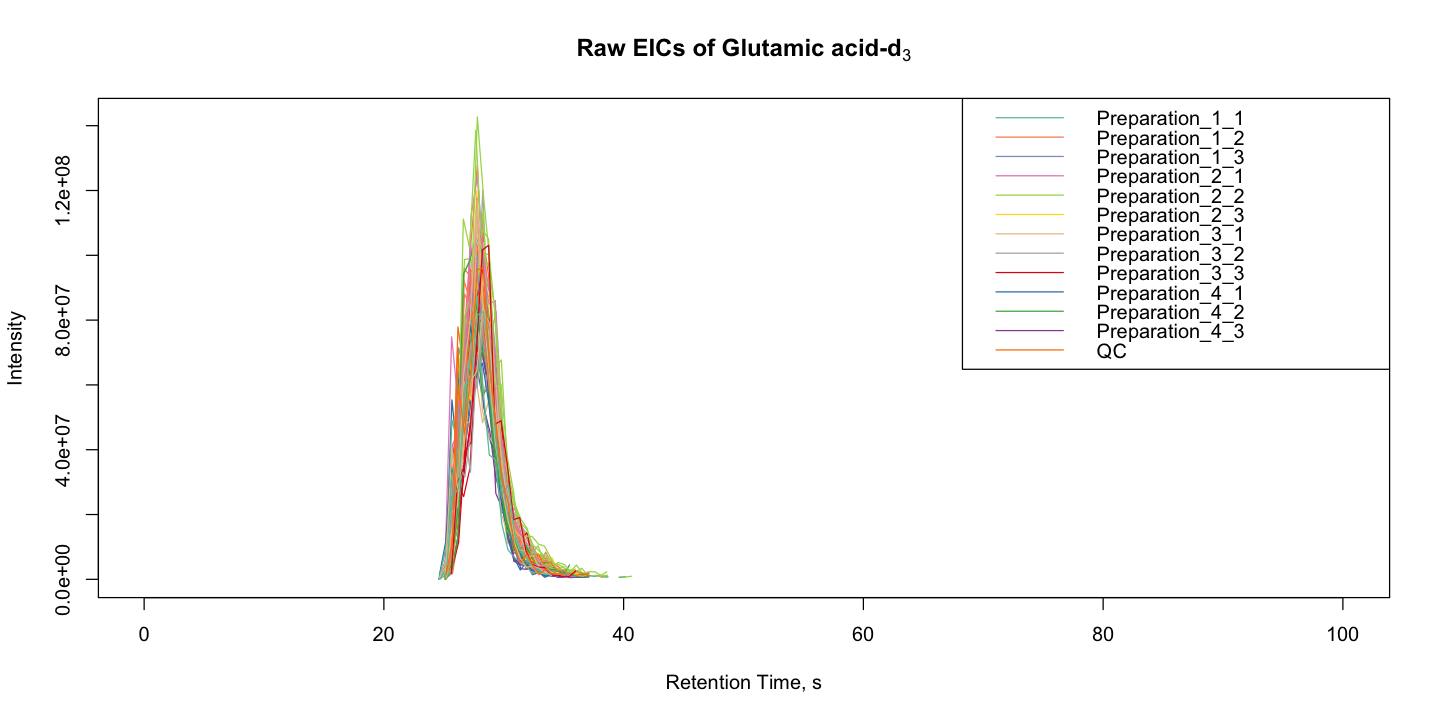

In [26]:
## Plot Carnitine-d9 before processing
glutd3.raw <- chromatogram(raw, mz = c(151.1430, 151.1450), rt = c(0, 100))

plot(glutd3.raw, col = group.colours[glutd3.raw$sample_group], 
     main = bquote(bold("Raw EICs of Glutamic acid-d"[3])), xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

In [27]:
## Identify rownumber of internal standard Glutamic acid d3
glutd3 <- results %>%
         rowData() %>%
         as.data.frame() %>%
         identify(mz = 151.1441, rt = 29, 5, 10)
glutd3 %>% head()

[1] 212

In [28]:
peaklist <- results %>%
assay("norm.weight")
glutd3 <- peaklist[212,]
area <- data.frame(glutd3)
preparation <- colData(results)$sample_group
glutd3 <- cbind(area, preparation)
glutd3 %>% head()

,glutd3,preparation
,<dbl>,<chr>
QC_1.mzXML,64974971,QC
QC_10.mzXML,66742835,QC
QC_11.mzXML,59500901,QC
QC_2.mzXML,57259952,QC
QC_3.mzXML,60691443,QC
Preparation_1_3__2.mzXML,70688150,Preparation_1_3


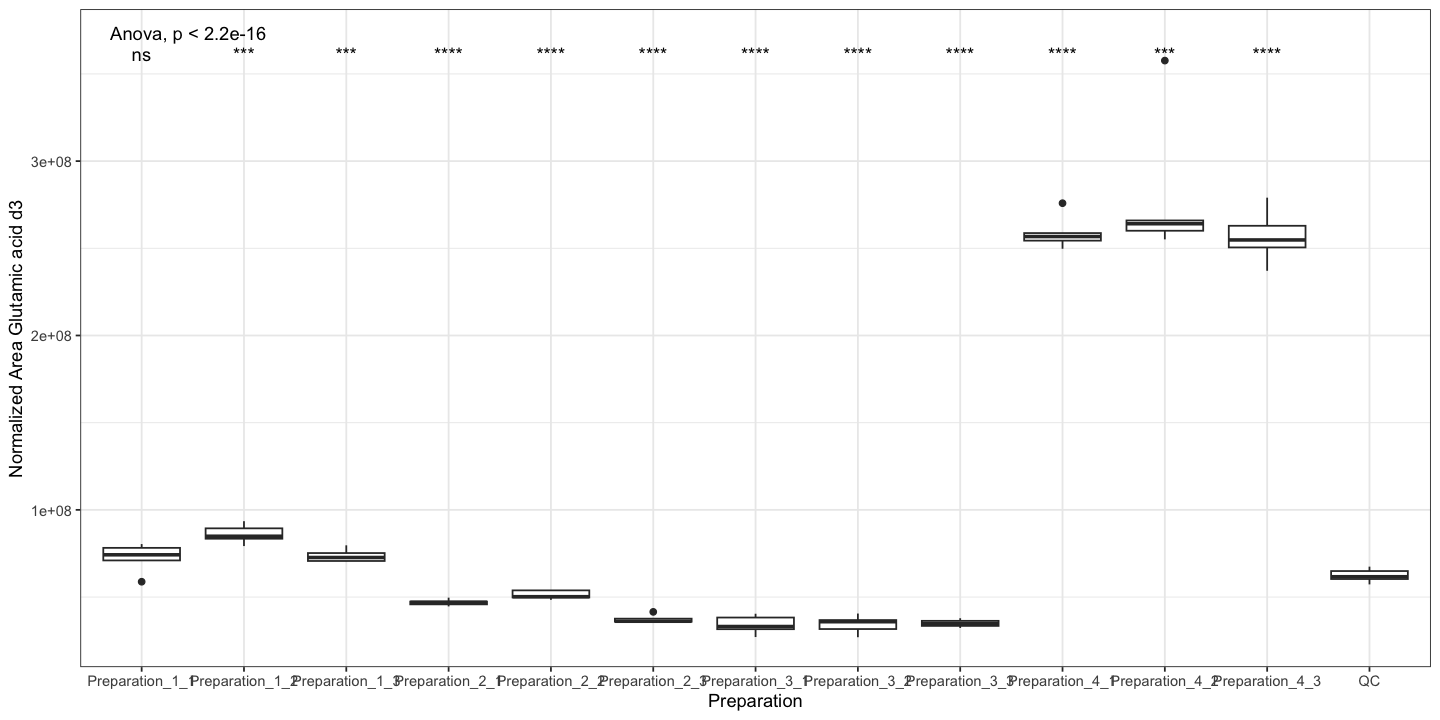

In [29]:
## Plot Area of IS of all extractions
ggplot(glutd3, aes(x = factor(preparation), y = glutd3)) +
  geom_boxplot(aes(group = preparation),) +
  stat_compare_means(method = "anova", label.y = 3.7e+08)+
  stat_compare_means(label = "p.signif", method = "t.test", ref.group = "QC") +
  xlab("Preparation") +
  ylab("Normalized Area Glutamic acid d3") +
  scale_x_discrete(limits = c("Preparation_1_1", "Preparation_1_2", "Preparation_1_3", "Preparation_2_1", "Preparation_2_2",
                          "Preparation_2_3", "Preparation_3_1", "Preparation_3_2", "Preparation_3_3", "Preparation_4_1", 
                          "Preparation_4_2", "Preparation_4_3", "QC")) +
  theme_bw()

### Hypoxanthin d4

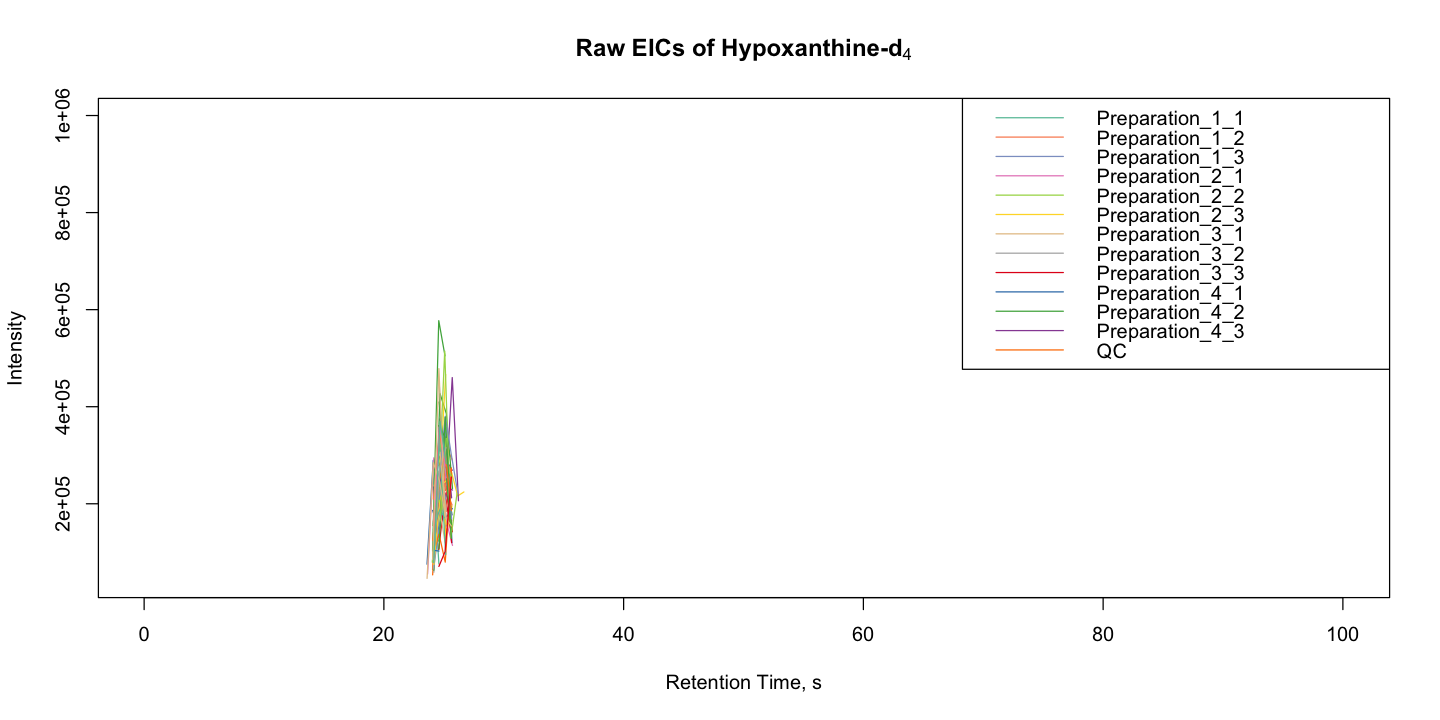

In [30]:
## Plot Carnitine-d9 before processing
hypd4.raw <- chromatogram(raw, mz = c(141.0690, 141.0720), rt = c(0, 100))

plot(hypd4.raw, col = group.colours[hypd4.raw$sample_group], 
     main = bquote(bold("Raw EICs of Hypoxanthine-d"[4])), xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

###  Kynurenic acid d5

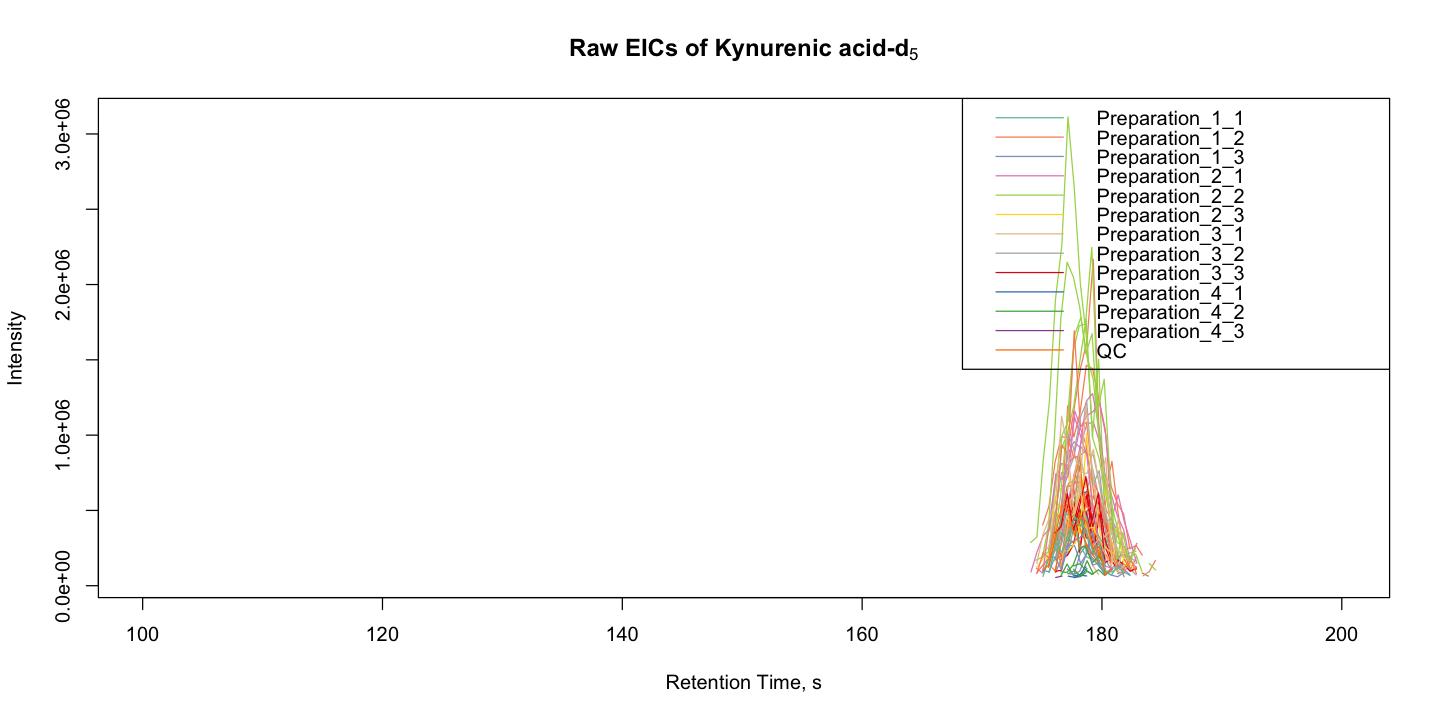

In [32]:
## Plot Carnitine-d9 before processing
kynd5.raw <- chromatogram(raw, mz = c(195.0805, 195.0820), rt = c(100, 200))

plot(kynd5.raw, col = group.colours[kynd5.raw$sample_group], 
     main = bquote(bold("Raw EICs of Kynurenic acid-d"[5])), xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

In [33]:
## Identify rownumber of internal standard Kynurenic acid d5 
kynd5 <- results %>%
         rowData() %>%
         as.data.frame() %>%
         identify(mz = 195.0813, rt = 179, 5, 10)
kynd5 %>% head()

[1] 351

In [34]:
peaklist <- results %>%
assay("norm.weight")
kynd5 <- peaklist[351,]
area <- data.frame(kynd5)
preparation <- colData(results)$sample_group
kynd5 <- cbind(area, preparation)
kynd5 %>% head()

,kynd5,preparation
,<dbl>,<chr>
QC_1.mzXML,405033.7,QC
QC_10.mzXML,313447.4,QC
QC_11.mzXML,324655.6,QC
QC_2.mzXML,493437.7,QC
QC_3.mzXML,400696.4,QC
Preparation_1_3__2.mzXML,179022.1,Preparation_1_3


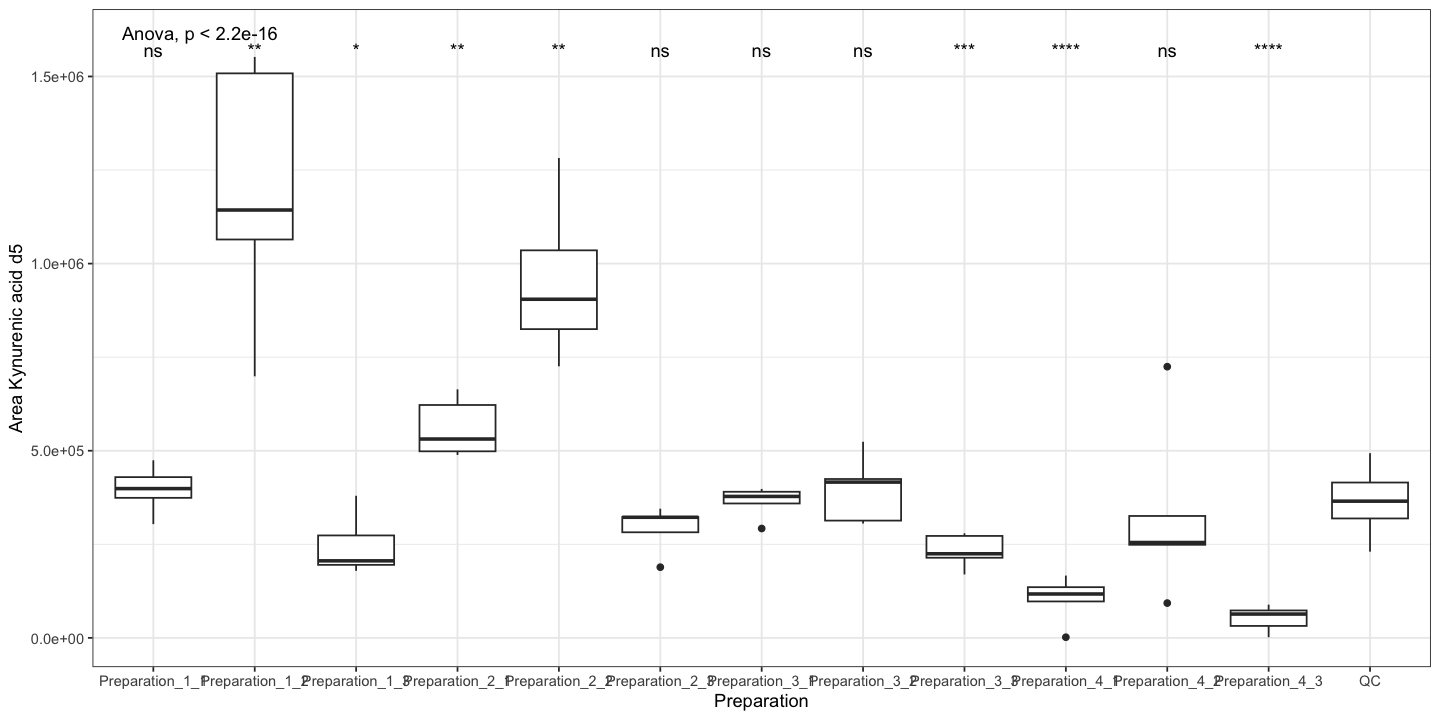

In [35]:
## Plot Area of IS of all extractions
ggplot(kynd5, aes(x = factor(preparation), y = kynd5)) +
 geom_boxplot(aes(group = preparation),) +
  stat_compare_means(method = "anova", label.y = 1.6e+06)+
  stat_compare_means(label = "p.signif", method = "t.test", ref.group = "QC") +
  xlab("Preparation") +
  ylab("Area Kynurenic acid d5") +
  scale_x_discrete(limits = c("Preparation_1_1", "Preparation_1_2", "Preparation_1_3", "Preparation_2_1", "Preparation_2_2",
                          "Preparation_2_3", "Preparation_3_1", "Preparation_3_2", "Preparation_3_3", "Preparation_4_1", 
                          "Preparation_4_2", "Preparation_4_3", "QC")) +
  theme_bw()

### Lysin d3

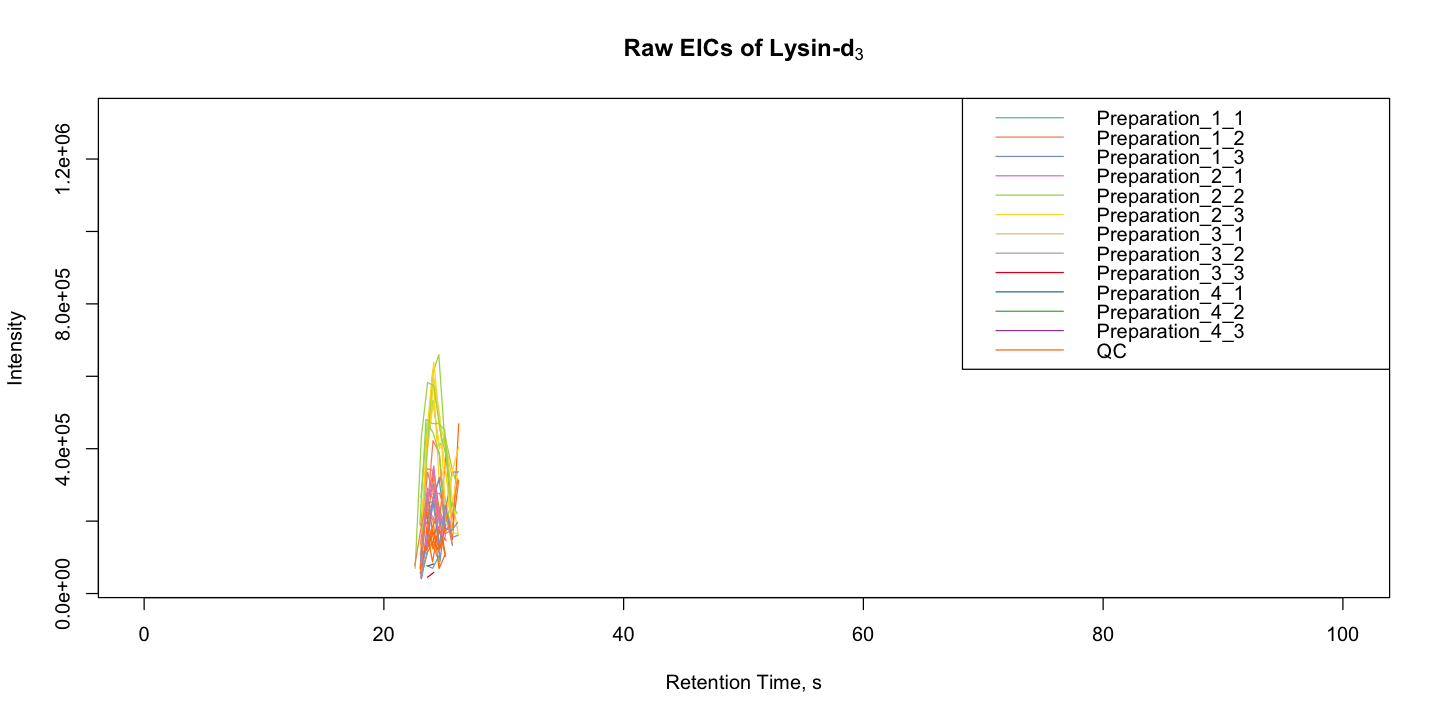

In [36]:
## Plot Carnitine-d9 before processing
lysd3.raw <- chromatogram(raw, mz = c(150.1300, 150.1325), rt = c(0, 100))

plot(lysd3.raw, col = group.colours[lysd3.raw$sample_group], 
     main = bquote(bold("Raw EICs of Lysin-d"[3])), xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

In [37]:
## Identify rownumber of internal standard Lysin d3
lysd3 <- results %>%
         rowData() %>%
         as.data.frame() %>%
         identify(mz = 150.1316, rt = 24, 5, 10)
lysd3 %>% head()

[1] 199

In [38]:
peaklist <- results %>%
assay("norm.weight")
lysd3 <- peaklist[199,]
area <- data.frame(lysd3)
preparation <- colData(results)$sample_group
lysd3 <- cbind(area, preparation)
lysd3 %>% head()

,lysd3,preparation
,<dbl>,<chr>
QC_1.mzXML,222326.2,QC
QC_10.mzXML,485199.5,QC
QC_11.mzXML,224694.8,QC
QC_2.mzXML,173981.9,QC
QC_3.mzXML,305150.2,QC
Preparation_1_3__2.mzXML,143021.5,Preparation_1_3


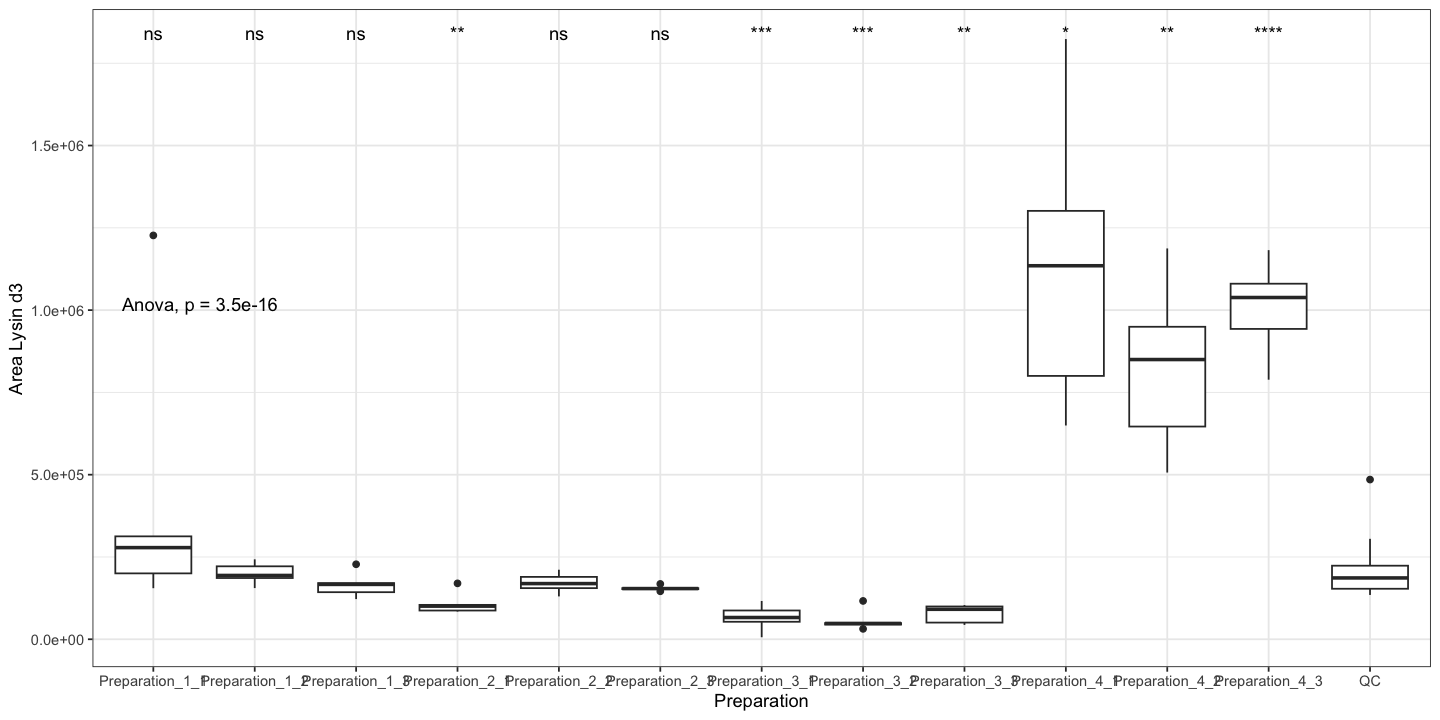

In [39]:
## Plot Area of IS of all extractions
ggplot(lysd3, aes(x = factor(preparation), y = lysd3)) +
  geom_boxplot(aes(group = preparation),) +
  stat_compare_means(method = "anova", label.y = 1e+06)+
  stat_compare_means(label = "p.signif", method = "t.test", ref.group = "QC") +
  xlab("Preparation") +
  ylab("Area Lysin d3") +
  scale_x_discrete(limits = c("Preparation_1_1", "Preparation_1_2", "Preparation_1_3", "Preparation_2_1", "Preparation_2_2",
                          "Preparation_2_3", "Preparation_3_1", "Preparation_3_2", "Preparation_3_3", "Preparation_4_1", 
                          "Preparation_4_2", "Preparation_4_3", "QC")) +
  theme_bw()

### Trp-d5

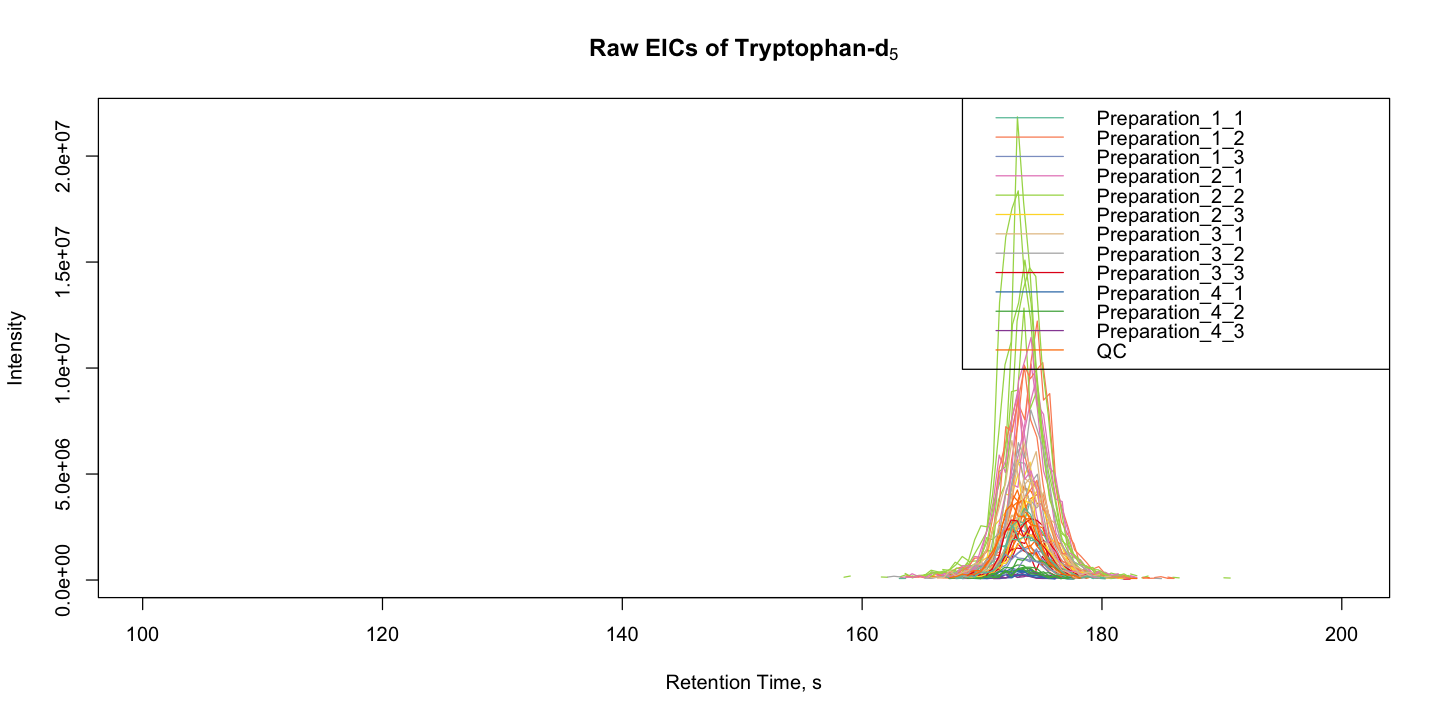

In [40]:
## Plot Carnitine-d9 before processing
trpd5.raw <- chromatogram(raw, mz = c(210.1280, 210.1300), rt = c(100, 200))

plot(trpd5.raw, col = group.colours[trpd5.raw$sample_group], 
     main = bquote(bold("Raw EICs of Tryptophan-d"[5])), xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

In [41]:
## Identify rownumber of internal standard tryptophan-d5
trpd5 <- results %>%
         rowData() %>%
         as.data.frame() %>%
         identify(mz = 210.1291, rt = 174, 5, 10)
trpd5 %>% head()

[1] 394

In [42]:
peaklist <- results %>%
assay("norm.weight")
trpd5 <- peaklist[394,]
area <- data.frame(trpd5)
preparation <- colData(results)$sample_group
trpd5 <- cbind(area, preparation)
trpd5 %>% head()

,trpd5,preparation
,<dbl>,<chr>
QC_1.mzXML,2748825,QC
QC_10.mzXML,2159739,QC
QC_11.mzXML,2382324,QC
QC_2.mzXML,3722821,QC
QC_3.mzXML,3345635,QC
Preparation_1_3__2.mzXML,1649702,Preparation_1_3


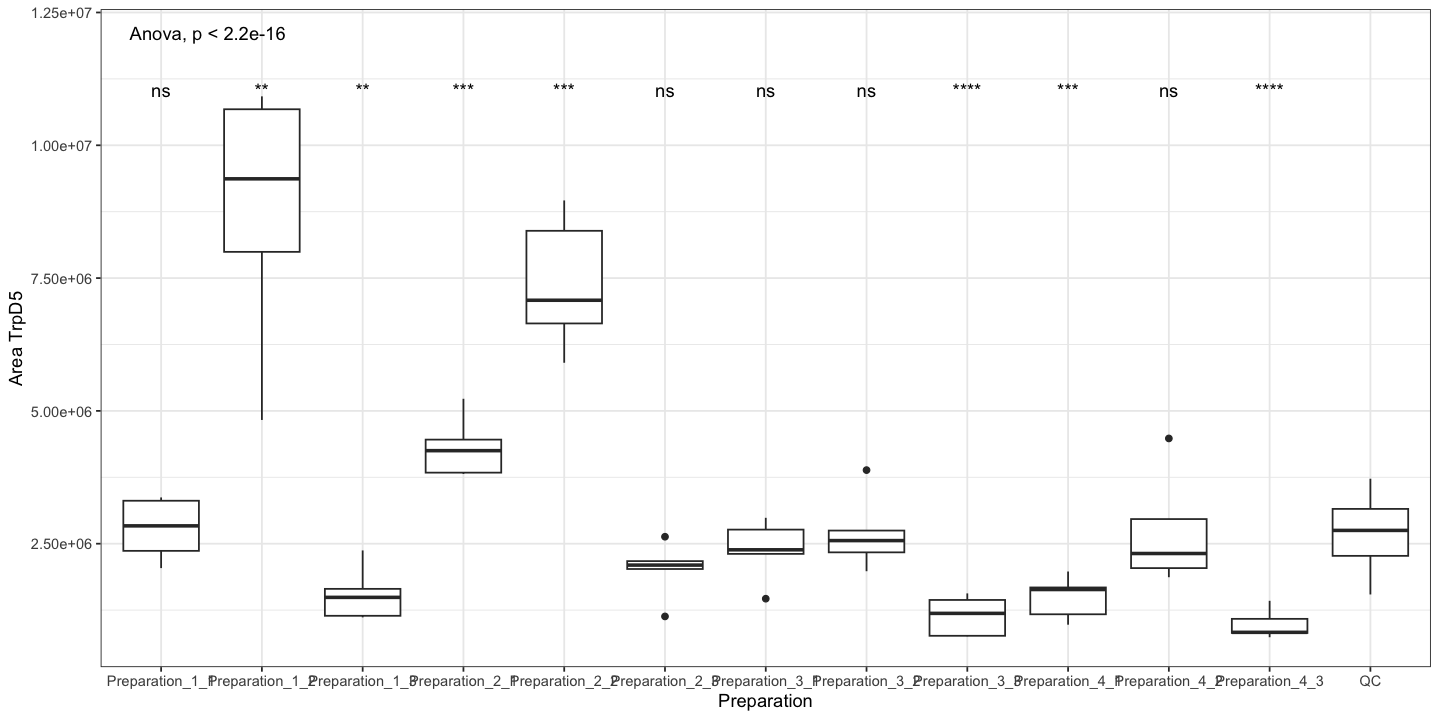

In [43]:
## Plot Area IS of all extractions to Reference Group QC
ggplot(trpd5, aes(x = factor(preparation), y = trpd5)) +
  geom_boxplot(aes(group = preparation),) +
  stat_compare_means(method = "anova", label.y = 1.2e+07)+
  stat_compare_means(label = "p.signif", method = "t.test", ref.group = "QC") +
  xlab("Preparation") +
  ylab("Area TrpD5") +
  scale_x_discrete(limits = c("Preparation_1_1", "Preparation_1_2", "Preparation_1_3", "Preparation_2_1", "Preparation_2_2",
                          "Preparation_2_3", "Preparation_3_1", "Preparation_3_2", "Preparation_3_3", "Preparation_4_1", 
                          "Preparation_4_2", "Preparation_4_3", "QC")) +
  theme_bw()

## IS Area for IS in Reconstitution Solvent 

Positive:
- n.d.: Arginine d7: m/z 182.1629, rt 28 sec (HILIC 500 sec)
- n.d.: Aspartic acid d3: m/z 137.0636, rt 28 sec (HILIC 498 sec)
- n.d.: Creatinine d3: m/z 117.0850, rt 30 sec (HILIC 285 sec)
- Cytosine d2: m/z 114.0631, rt 30 sec (HILIC 329 sec)
- n.d.: Glycin N15: m/z 77.0363 (neg:75.0218), rt / sec (HILIC / sec)
- n.d.: Thymidine d4: m/z 247.1227, rt 0 sec (HILIC 198 sec)

Negative:
- Arginine d7: m/z 180.1483, rt 28 sec (HILIC 500 sec)
- Aspartic acid d3: m/z 135.0491, rt 28 sec (HILIC 498 sec)
- Cortisol d4: m/z 365.2271, rt 598 sec (HILIC / sec)
- Glucose d7: m/z 186.1000, rt 29 sec (HILIC 456 sec)
- Stearic acid 13C: m/z 284.2676, rt / sec (HILIC 69 sec)
- Thymidine d4: m/z 245.1081, rt 0 sec (HILIC 198 sec)

### Cytosine-d2

In [44]:
## Identify rownumber of internal standard tryptophan-d5
cytd2 <- results %>%
         rowData() %>%
         as.data.frame() %>%
         identify(mz = 114.0665, rt = 30, 5, 10)
cytd2 %>% head()

[1] 87

In [45]:
peaklist <- results %>%
assay("raw")
cytd2 <- peaklist[87,]
area <- data.frame(cytd2)
preparation <- colData(results)$sample_group
cytd2 <- cbind(area, preparation)
cytd2 %>% head()

,cytd2,preparation
,<dbl>,<chr>
QC_1.mzXML,3570217996,QC
QC_10.mzXML,3651361425,QC
QC_11.mzXML,3580965491,QC
QC_2.mzXML,3444607209,QC
QC_3.mzXML,3574291904,QC
Preparation_1_3__2.mzXML,3661487442,Preparation_1_3


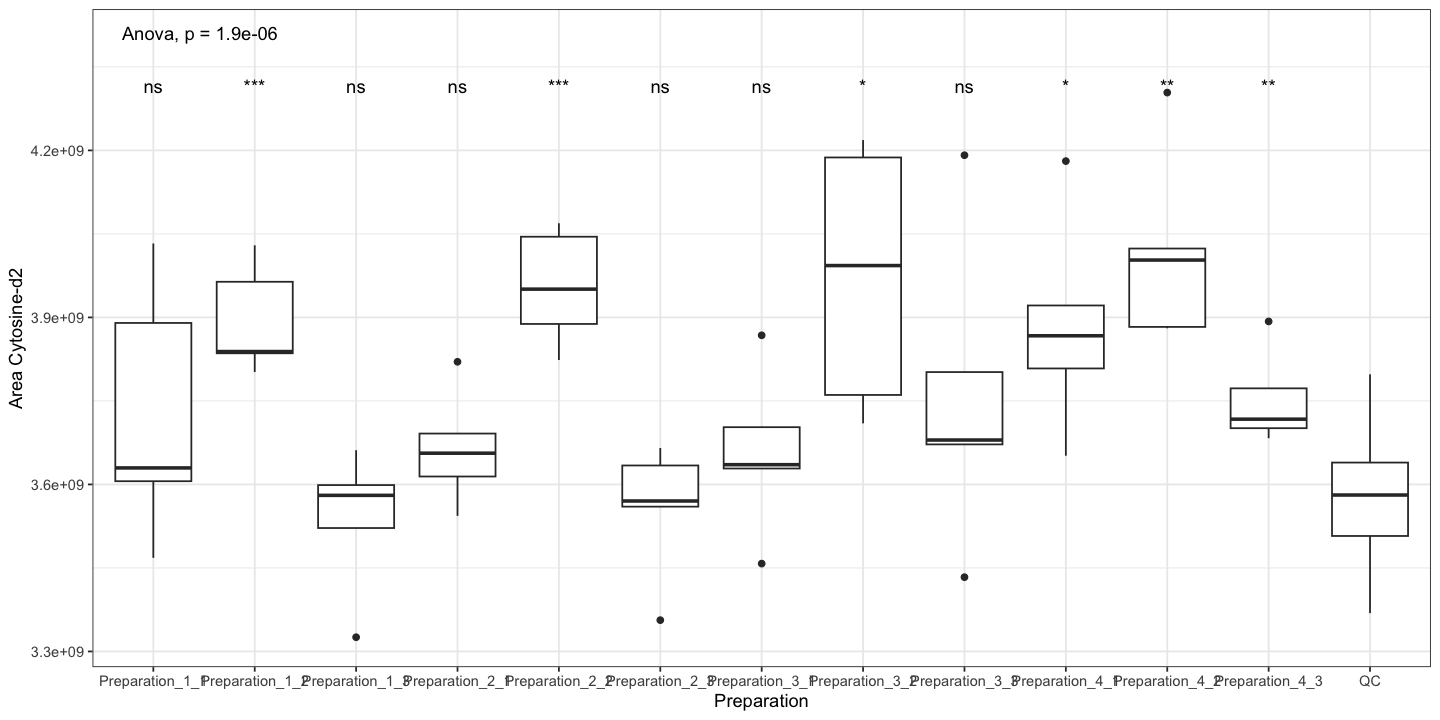

In [46]:
## Plot Area IS of all extractions to Reference Group QC
ggplot(cytd2, aes(x = factor(preparation), y = cytd2)) +
  geom_boxplot(aes(group = preparation),) +
  stat_compare_means(method = "anova", label.y = 4.4e+09)+
  stat_compare_means(label = "p.signif", method = "t.test", ref.group = "QC") +
  xlab("Preparation") +
  ylab("Area Cytosine-d2") +
  scale_x_discrete(limits = c("Preparation_1_1", "Preparation_1_2", "Preparation_1_3", "Preparation_2_1", "Preparation_2_2",
                          "Preparation_2_3", "Preparation_3_1", "Preparation_3_2", "Preparation_3_3", "Preparation_4_1", 
                          "Preparation_4_2", "Preparation_4_3", "QC")) +
  theme_bw()

In [47]:
write_xlsx(list(glutd3 = as.data.frame(glutd3), 
                trpd5 = as.data.frame(trpd5),
                kynd5 = as.data.frame(kynd5),
                lysd3 = as.data.frame(lysd3),
                cytd2 = as.data.frame(cytd2)), 
           "Human_Urine_Extraction_C18_pos_IS.xlsx")

## Feature Summary for all IS

In [48]:
Summaryfeature <- featureSummary(set, set$sample_group , perSampleCounts = TRUE, method = "maxint", skipFilled = TRUE)
Summaryfeature %>% head()

,count,perc,multi_count,multi_perc,rsd,QC_count,QC_perc,QC_multi_count,QC_multi_perc,QC_rsd,⋯,Preparation_1_1__3.mzXML,Preparation_1_2__1.mzXML,Preparation_2_1__3.mzXML,Preparation_3_1__3.mzXML,Preparation_3_2__4.mzXML,Preparation_3_1__1.mzXML,Preparation_3_3__3.mzXML,Preparation_3_1__2.mzXML,Preparation_1_1__4.mzXML,QC_9.mzXML
FT0001,19,26.76056,0,0,0.2887127,4,36.36364,0,0,0.3569644,⋯,0,1,0,0,0,0,1,0,0,1
FT0002,14,19.71831,0,0,0.2820131,2,18.18182,0,0,0.8524186,⋯,0,1,0,0,0,0,1,0,0,0
FT0003,26,36.61972,0,0,0.2371487,3,27.27273,0,0,0.3583379,⋯,0,1,0,0,1,0,0,0,0,0
FT0004,46,64.78873,0,0,0.2192007,10,90.90909,0,0,0.3861181,⋯,1,1,1,1,0,1,1,1,1,1
FT0005,45,63.38028,0,0,0.2247996,10,90.90909,0,0,0.3965337,⋯,1,1,0,1,0,1,1,1,1,1
FT0006,33,46.47887,0,0,0.3132815,7,63.63636,0,0,0.2162643,⋯,0,1,0,0,0,0,0,0,1,1


In [49]:
write_xlsx(as.data.frame(Summaryfeature), "Summaryfeature.xlsx")

In [50]:
peakdata <- as.data.frame(rowData(results))
IS <- Summaryfeature[c(87,199,212,351,394),]
#IS.peakdata <- peakdata[c(87,199,212,351,394),]
#SumFeat <- cbind(IS.peakdata, c(IS))
IS %>% head()

,count,perc,multi_count,multi_perc,rsd,QC_count,QC_perc,QC_multi_count,QC_multi_perc,QC_rsd,⋯,Preparation_1_1__3.mzXML,Preparation_1_2__1.mzXML,Preparation_2_1__3.mzXML,Preparation_3_1__3.mzXML,Preparation_3_2__4.mzXML,Preparation_3_1__1.mzXML,Preparation_3_3__3.mzXML,Preparation_3_1__2.mzXML,Preparation_1_1__4.mzXML,QC_9.mzXML
FT0087,71,100.00000,0,0,0.05872956,11,100.00000,0,0,0.03666596,⋯,1,1,1,1,1,1,1,1,1,1
FT0199,25,35.21127,1,4,0.78302529,3,27.27273,0,0,0.72545516,⋯,0,1,0,0,0,0,0,0,1,0
FT0212,71,100.00000,0,0,0.15993404,11,100.00000,0,0,0.05132683,⋯,1,1,1,1,1,1,1,1,1,1
FT0351,56,78.87324,0,0,0.69113870,11,100.00000,0,0,0.21531087,⋯,1,1,1,1,1,1,1,1,1,1
FT0394,69,97.18310,0,0,0.91035943,11,100.00000,0,0,0.24268157,⋯,1,1,1,1,1,1,1,1,1,1


In [51]:
write_xlsx(as.data.frame(IS), "Summaryfeature.IS.xlsx")

## Export data set for additional evaluations

In [69]:
write_xlsx(list(areas = as.data.frame(assay(results, "raw")), 
                peakdata = as.data.frame(rowData(results)), 
                filedata = as.data.frame(colData(results))), 
           "Rat_Urine_Extraction_C18_pos_count.xlsx")

## Save dataset

In [70]:
save.image("Rat_Urine_Extraction_C18_pos_sig.RData")

In [71]:
results <- quantify(set, value = "into")
class(results)

[1] "SummarizedExperiment"
attr(,"package")
[1] "SummarizedExperiment"

In [72]:
## Add classic feature names
rowData(results)$label <- paste0("M",round(rowData(results)$mzmed,0),
                           "T", round(rowData(results)$rtmed,0))

## Feature Count

In [73]:
peaklist <- results %>%
assay("raw")
peaklist <- as.data.frame(t(peaklist))
peaklist %>% head()
write.csv(peaklist, "peaklist.csv")

,FT0001,FT0002,FT0003,FT0004,FT0005,FT0006,FT0007,FT0008,FT0009,FT0010,⋯,FT1065,FT1066,FT1067,FT1068,FT1069,FT1070,FT1071,FT1072,FT1073,FT1074
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
QC_1.mzXML,924487.6,620392.7,1648181.4,1250271,1146380,276291274,5.973966e+05,18202139,25096628,5688996,⋯,168573.41,321635.4,112823.55,35577.89,1169025.4,568994.5,282718.3,172633.3,NA,74558.03
QC_10.mzXML,2216680.9,1228453.5,786736.5,27250490,25516131,173135112,NA,17751599,25345117,7759251,⋯,273039.04,636054.5,186303.63,39463.67,682913.1,174740.3,571443.1,175532.1,254479.48,109503.37
QC_11.mzXML,2035974.2,1555238.9,1230258.5,24373440,23174567,216235328,1.833601e+09,25413270,30344414,9952030,⋯,180194.09,570479.1,244120.67,73576.84,1469128.9,391309.9,544262.7,499779.5,169650.21,139218.06
QC_2.mzXML,3215056.9,1389095.4,1775588.9,43210981,35656527,88587697,2.923018e+08,14879040,10041394,6240598,⋯,58314.31,309948.6,104536.33,36517.91,1385383.7,420009.8,212724.6,195025.6,56523.04,76898.96
QC_3.mzXML,3056716.3,2933144.0,966766.4,32062453,41685677,286479506,1.431095e+09,8480695,14567652,6376861,⋯,99854.51,353449.7,63817.75,45147.83,1380317.0,508642.5,250024.3,167368.7,74964.04,51182.62
Preparation_1_3__2.mzXML,2605832.1,1771542.2,3069685.9,13440008,9921954,200906631,1.298975e+09,15581146,28306908,8643731,⋯,305518.99,556511.0,127987.08,99835.94,645012.6,191470.6,679819.5,124604.8,284813.27,164203.05


In [74]:
## Plot feature count (peaknumber)
peaklist[peaklist == 0] <- NA
peaklist[is.na(peaklist) == FALSE] <- 1
peaklist[is.na(peaklist) == TRUE] <- 0
#peaklist$Sum <- apply(peaklist, 1, sum)
count <- apply(peaklist, 1, sum)
count <- as.data.frame(count)
preparation <- colData(results)$sample_group
preparation <- as.data.frame(preparation)
peaklist <- cbind(peaklist, c(count), c(preparation))

peaknumber_order <- c("Preparation_1_1", "Preparation_1_2", "Preparation_1_3", "Preparation_2_1", "Preparation_2_2",
                          "Preparation_2_3", "Preparation_3_1", "Preparation_3_2", "Preparation_3_3", "Preparation_4_1", 
                          "Preparation_4_2", "Preparation_4_3", "QC")
peaklist <- peaklist[!(row.names(peaklist) %in% c("QC_1.mzXML","QC_2.mzXML","QC_3.mzXML","QC_4.mzXML","QC_5.mzXML",
                                                 "QC_6.mzXML","QC_7.mzXML","QC_8.mzXML","QC_9.mzXML","QC_10.mzXML","QC_11.mzXML")),]
peaklist %>% head()
#count %>% head()

,FT0001,FT0002,FT0003,FT0004,FT0005,FT0006,FT0007,FT0008,FT0009,FT0010,⋯,FT1067,FT1068,FT1069,FT1070,FT1071,FT1072,FT1073,FT1074,count,preparation
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Preparation_1_3__2.mzXML,1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1037,Preparation_1_3
Preparation_2_3__4.mzXML,1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1027,Preparation_2_3
Preparation_4_1__3.mzXML,1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1028,Preparation_4_1
Preparation_2_3__5.mzXML,1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1035,Preparation_2_3
Preparation_2_1__5.mzXML,1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1047,Preparation_2_1
Preparation_1_1__2.mzXML,1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1046,Preparation_1_1


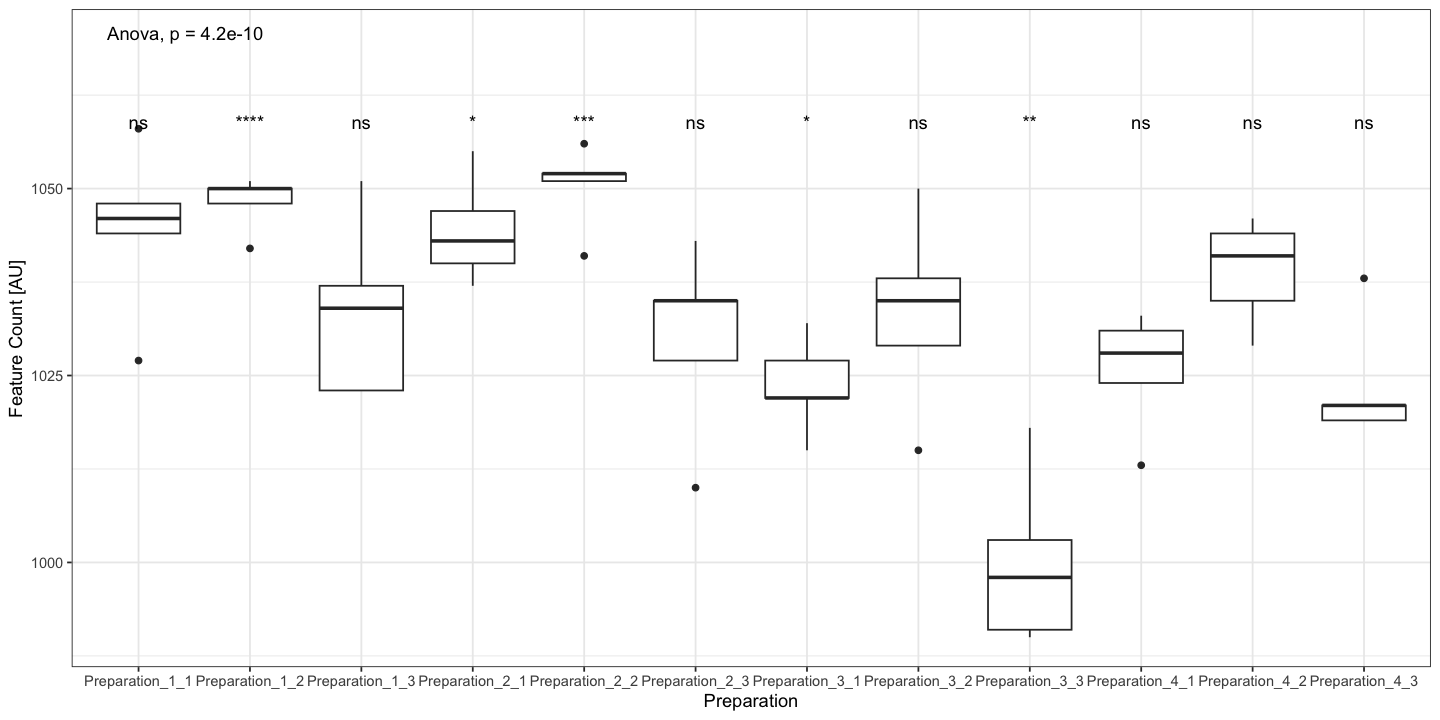

In [77]:
## Plot peaknumber of all extractions
ggplot(peaklist, aes(x = factor(preparation, level = peaknumber_order), y = count)) +
  geom_boxplot(aes(group = preparation),) +
  stat_compare_means(method = "anova", label.y = 1070)+
  stat_compare_means(label = "p.signif", method = "t.test", ref.group = ".all.") +
  xlab("Preparation") +
  ylab("Feature Count [AU]") +
  scale_x_discrete(limits = c("Preparation_1_1", "Preparation_1_2", "Preparation_1_3", "Preparation_2_1", "Preparation_2_2",
                          "Preparation_2_3", "Preparation_3_1", "Preparation_3_2", "Preparation_3_3", "Preparation_4_1", 
                          "Preparation_4_2", "Preparation_4_3")) +
  theme_bw()

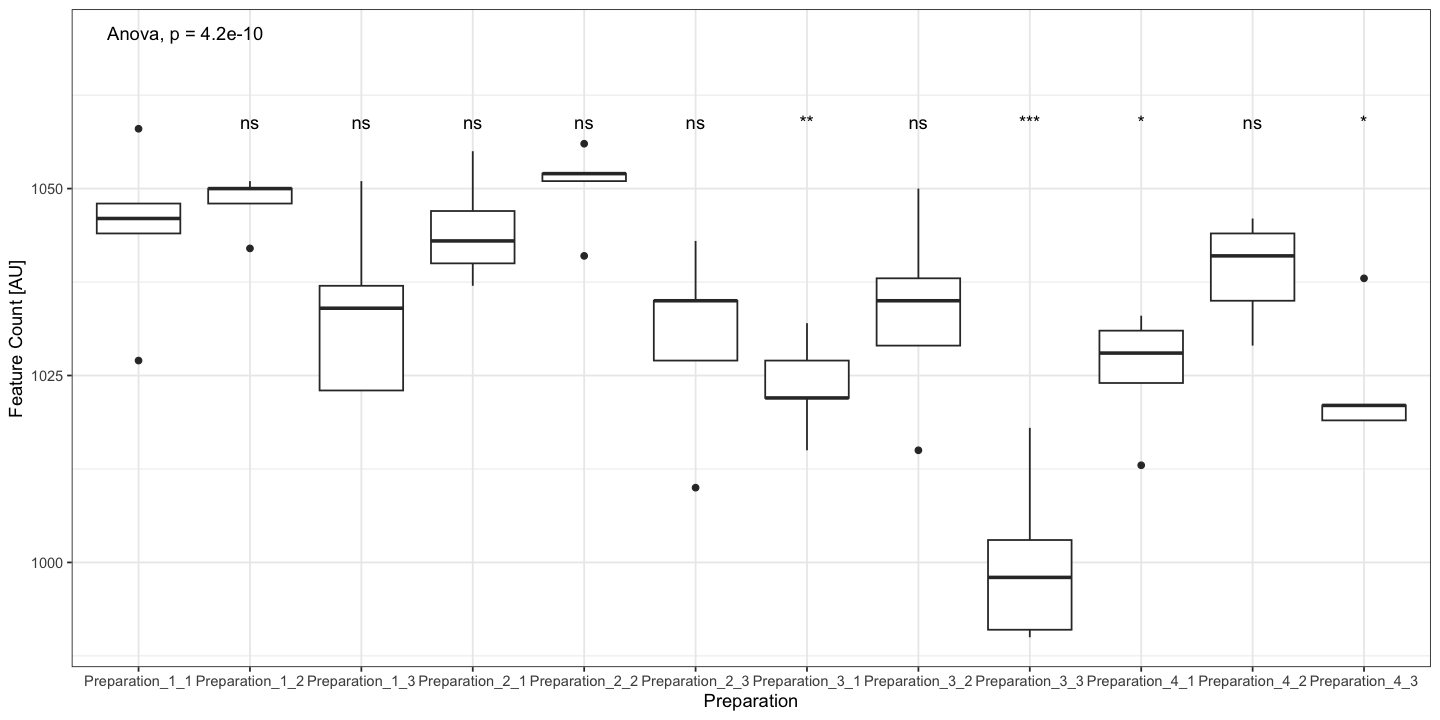

In [78]:
## Plot peaknumber of all extractions
ggplot(peaklist, aes(x = factor(preparation, level = peaknumber_order), y = count)) +
  geom_boxplot(aes(group = preparation),) +
  stat_compare_means(method = "anova", label.y = 1070)+
  stat_compare_means(label = "p.signif", method = "t.test", ref.group = "Preparation_1_1") +
  xlab("Preparation") +
  ylab("Feature Count [AU]") +
  scale_x_discrete(limits = c("Preparation_1_1", "Preparation_1_2", "Preparation_1_3", "Preparation_2_1", "Preparation_2_2",
                          "Preparation_2_3", "Preparation_3_1", "Preparation_3_2", "Preparation_3_3", "Preparation_4_1", 
                          "Preparation_4_2", "Preparation_4_3")) +
  theme_bw()

In [79]:
## Export Feature Count Table
Peaknumber_Results <- as.data.frame(count)
colnames(Peaknumber_Results) <- "Feature_count"
Peaknumber_Results$Sample <- rownames(count)
write.csv(Peaknumber_Results, "Feature_Count.csv")

# Feature Count CV<20

In [80]:
Preparation_1_1 <- results[,results$sample_group == "Preparation_1_1"] %>%
               assay("raw")
cv <- apply(Preparation_1_1, 1, function(x) sd(x, na.rm=T)/mean(x, na.rm=T)*100)
Preparation_1_1_cv <- cbind(Preparation_1_1,c(cv))
Preparation_1_1_cv20 <- Preparation_1_1_cv[which(cv <= 20),]
Preparation_1_1_cv20 <- nrow(Preparation_1_1_cv20)

Preparation_1_2 <- results[,results$sample_group == "Preparation_1_2"] %>%
               assay("raw")
cv <- apply(Preparation_1_2, 1, function(x) sd(x, na.rm=T)/mean(x, na.rm=T)*100)
Preparation_1_2_cv <- cbind(Preparation_1_2,c(cv))
Preparation_1_2_cv20 <- Preparation_1_2_cv[which(cv <= 20),]
Preparation_1_2_cv20 <-nrow(Preparation_1_2_cv20)
            
Preparation_1_3 <- results[,results$sample_group == "Preparation_1_3"] %>%
               assay("raw")
cv <- apply(Preparation_1_3, 1, function(x) sd(x, na.rm=T)/mean(x, na.rm=T)*100)
Preparation_1_3_cv <- cbind(Preparation_1_3,c(cv))
Preparation_1_3_cv20 <- Preparation_1_3_cv[which(cv <= 20),]
Preparation_1_3_cv20 <- nrow(Preparation_1_3_cv20)
            
Preparation_2_1 <- results[,results$sample_group == "Preparation_2_1"] %>%
               assay("raw")
cv <- apply(Preparation_2_1, 1, function(x) sd(x, na.rm=T)/mean(x, na.rm=T)*100)
Preparation_2_1_cv <- cbind(Preparation_2_1,c(cv))
Preparation_2_1_cv20 <- Preparation_2_1_cv[which(cv <= 20),]
Preparation_2_1_cv20 <- nrow(Preparation_2_1_cv20)
            
Preparation_2_2 <- results[,results$sample_group == "Preparation_2_2"] %>%
               assay("raw")
cv <- apply(Preparation_2_2, 1, function(x) sd(x, na.rm=T)/mean(x, na.rm=T)*100)
Preparation_2_2_cv <- cbind(Preparation_2_2,c(cv))
Preparation_2_2_cv20 <- Preparation_2_2_cv[which(cv <= 20),]
Preparation_2_2_cv20 <- nrow(Preparation_2_2_cv20)
            
Preparation_2_3 <- results[,results$sample_group == "Preparation_2_3"] %>%
               assay("raw")
cv <- apply(Preparation_2_3, 1, function(x) sd(x, na.rm=T)/mean(x, na.rm=T)*100)
Preparation_2_3_cv <- cbind(Preparation_2_3,c(cv))
Preparation_2_3_cv20 <- Preparation_2_3_cv[which(cv <= 20),]
Preparation_2_3_cv20 <- nrow(Preparation_2_3_cv20)
            
Preparation_3_1 <- results[,results$sample_group == "Preparation_3_1"] %>%
               assay("raw")
cv <- apply(Preparation_3_1, 1, function(x) sd(x, na.rm=T)/mean(x, na.rm=T)*100)
Preparation_3_1_cv <- cbind(Preparation_3_1,c(cv))
Preparation_3_1_cv20 <- Preparation_3_1_cv[which(cv <= 20),]
Preparation_3_1_cv20 <- nrow(Preparation_3_1_cv20)
            
Preparation_3_2 <- results[,results$sample_group == "Preparation_3_2"] %>%
               assay("raw")
cv <- apply(Preparation_3_2, 1, function(x) sd(x, na.rm=T)/mean(x, na.rm=T)*100)
Preparation_3_2_cv <- cbind(Preparation_3_2,c(cv))
Preparation_3_2_cv20 <- Preparation_3_2_cv[which(cv <= 20),]
Preparation_3_2_cv20 <- nrow(Preparation_3_2_cv20)
            
Preparation_3_3 <- results[,results$sample_group == "Preparation_3_3"] %>%
               assay("raw")
cv <- apply(Preparation_3_3, 1, function(x) sd(x, na.rm=T)/mean(x, na.rm=T)*100)
Preparation_3_3_cv <- cbind(Preparation_3_3,c(cv))
Preparation_3_3_cv20 <- Preparation_3_3_cv[which(cv <= 20),]
Preparation_3_3_cv20 <- nrow(Preparation_3_3_cv20)
            
Preparation_4_1 <- results[,results$sample_group == "Preparation_4_1"] %>%
               assay("raw")
cv <- apply(Preparation_4_1, 1, function(x) sd(x, na.rm=T)/mean(x, na.rm=T)*100)
Preparation_4_1_cv <- cbind(Preparation_4_1,c(cv))
Preparation_4_1_cv20 <- Preparation_4_1_cv[which(cv <= 20),]
Preparation_4_1_cv20 <- nrow(Preparation_4_1_cv20)  
            
Preparation_4_2 <- results[,results$sample_group == "Preparation_4_2"] %>%
               assay("raw")
cv <- apply(Preparation_4_2, 1, function(x) sd(x, na.rm=T)/mean(x, na.rm=T)*100)
Preparation_4_2_cv <- cbind(Preparation_4_2,c(cv))
Preparation_4_2_cv20 <- Preparation_4_2_cv[which(cv <= 20),]
Preparation_4_2_cv20 <- nrow(Preparation_4_2_cv20) 
            
Preparation_4_3 <- results[,results$sample_group == "Preparation_4_3"] %>%
               assay("raw")
cv <- apply(Preparation_4_3, 1, function(x) sd(x, na.rm=T)/mean(x, na.rm=T)*100)
Preparation_4_3_cv <- cbind(Preparation_4_3,c(cv))
Preparation_4_3_cv20 <- Preparation_4_3_cv[which(cv <= 20),]
Preparation_4_3_cv20 <- nrow(Preparation_4_3_cv20)

In [81]:
Preparation_CV20 <- c("Preparation_1_1" = Preparation_1_1_cv20, "Preparation_1_2" = Preparation_1_2_cv20,
                   "Preparation_1_3" = Preparation_1_3_cv20, "Preparation_2_1" = Preparation_2_1_cv20, 
                   "Preparation_2_2" = Preparation_2_2_cv20, "Preparation_2_3" = Preparation_2_3_cv20,
                   "Preparation_3_1" = Preparation_3_1_cv20, "Preparation_3_2" = Preparation_3_2_cv20,
                   "Preparation_3_3" = Preparation_3_3_cv20, "Preparation_4_1" = Preparation_4_1_cv20, 
                   "Preparation_4_2" = Preparation_4_2_cv20, "Preparation_4_3" = Preparation_4_3_cv20)
preparation <- c("Preparation_1_1", "Preparation_1_2", "Preparation_1_3", "Preparation_2_1", "Preparation_2_2",
                      "Preparation_2_3", "Preparation_3_1", "Preparation_3_2", "Preparation_3_3", "Preparation_4_1", 
                      "Preparation_4_2", "Preparation_4_3")
Preparation_CV20 <- cbind(Preparation_CV20, c(preparation))
Preparation_CV20 <- as.data.frame(Preparation_CV20)

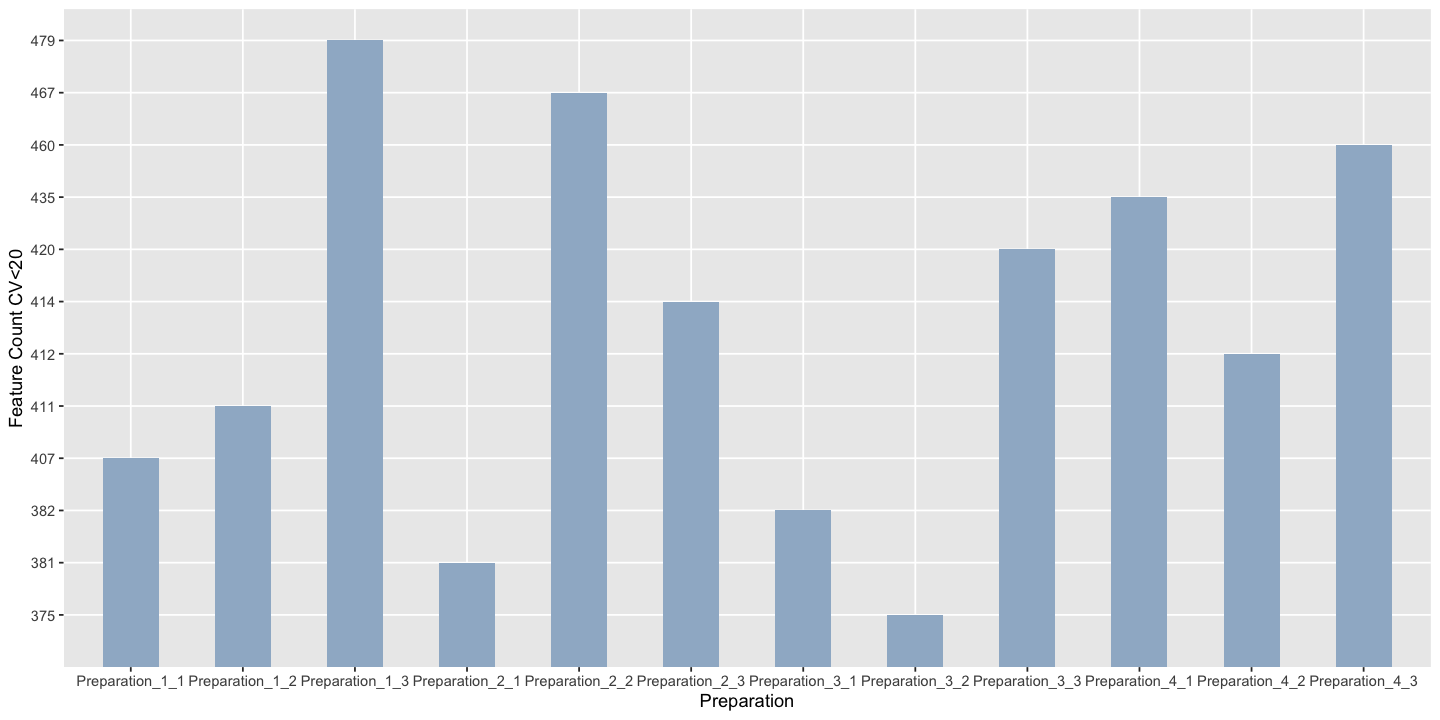

In [82]:
ggplot(Preparation_CV20, aes(preparation, Preparation_CV20))+
geom_col(fill="slategray3", width = 0.5)+
xlab("Preparation") +
ylab("Feature Count CV<20") 

In [83]:
write.csv(Preparation_CV20, "Feature_Count_CV20.csv")

## Save dataset

In [84]:
save.image("Human_Urine_Extraction_C18_pos_sig.RData")

# Summary Images

In [85]:
save.image("Human_Urine_Extraction_C18_pos_count.RData")

# Appendix

In [86]:
sessionInfo()

R version 4.2.2 (2022-10-31)
Platform: x86_64-apple-darwin17.0 (64-bit)
Running under: macOS Big Sur ... 10.16

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.2/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/4.2/Resources/lib/libRlapack.dylib

locale:
[1] de_DE.UTF-8/de_DE.UTF-8/de_DE.UTF-8/C/de_DE.UTF-8/de_DE.UTF-8

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] ggpubr_0.5.0                devtools_2.4.5             
 [3] usethis_2.1.6               writexl_1.4.2              
 [5] ggrepel_0.9.3               MASS_7.3-58.2              
 [7] caret_6.0-93                lattice_0.20-45            
 [9] Rtsne_0.16                  gplots_3.1.3               
[11] forcats_1.0.0               stringr_1.5.0              
[13] dplyr_1.1.0                 purrr_1.0.1                
[15] readr_2.1.4                 tidyr_1.3.0          